INFO:__main__:Starting D-WBL Feature Recommendation Analysis...
INFO:__main__:
Generating visualizations...
/tmp/ipykernel_2140/485841516.py:639: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=sizes, palette=colors, ax=ax2)



ANALYSIS RESULTS


--- 1. Sentiment Analysis Summary ---
{
  "total_analyzed": 11,
  "positive_count": 5,
  "negative_count": 2,
  "neutral_count": 4,
  "positive_ratio": 0.45454545454545453,
  "negative_ratio": 0.18181818181818182,
  "neutral_ratio": 0.36363636363636365,
  "average_sentiment_score": 0.13292727272727276,
  "overall_sentiment": "positive"
}

--- 2. Topic Analysis ---
  Topic 0: learning + adaptive + student engagement
    - Top Words: learning, adaptive, student engagement, online, online education
  Topic 1: sangat + bermanfaat tapi + bermanfaat
    - Top Words: sangat, bermanfaat tapi, bermanfaat, sesama, sering
  Topic 2: mentor + saya + mentor berpengalaman
    - Top Words: mentor, saya, mentor berpengalaman, saya butuh, butuh
  Topic 3: industry + student + platform
    - Top Words: industry, student, platform, work, graduates industry
  Topic 4: digital + system + career
    - Top Words: digital, system, career, personalized, tracking
  Topic 5: potential + bette

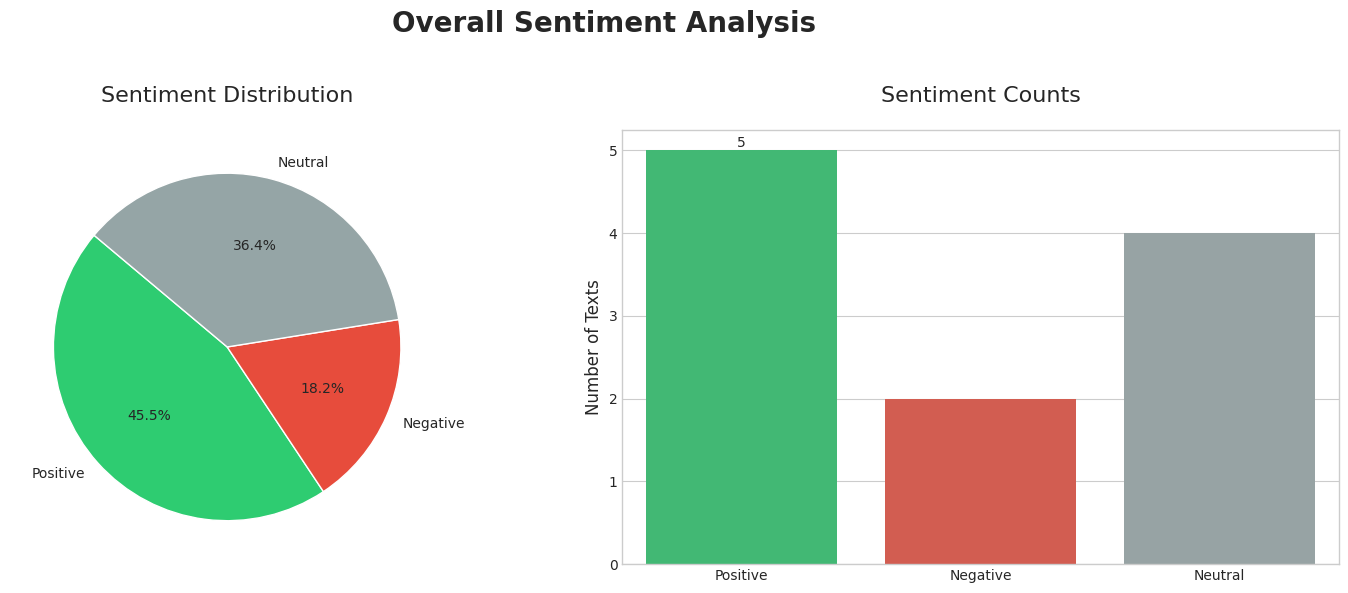

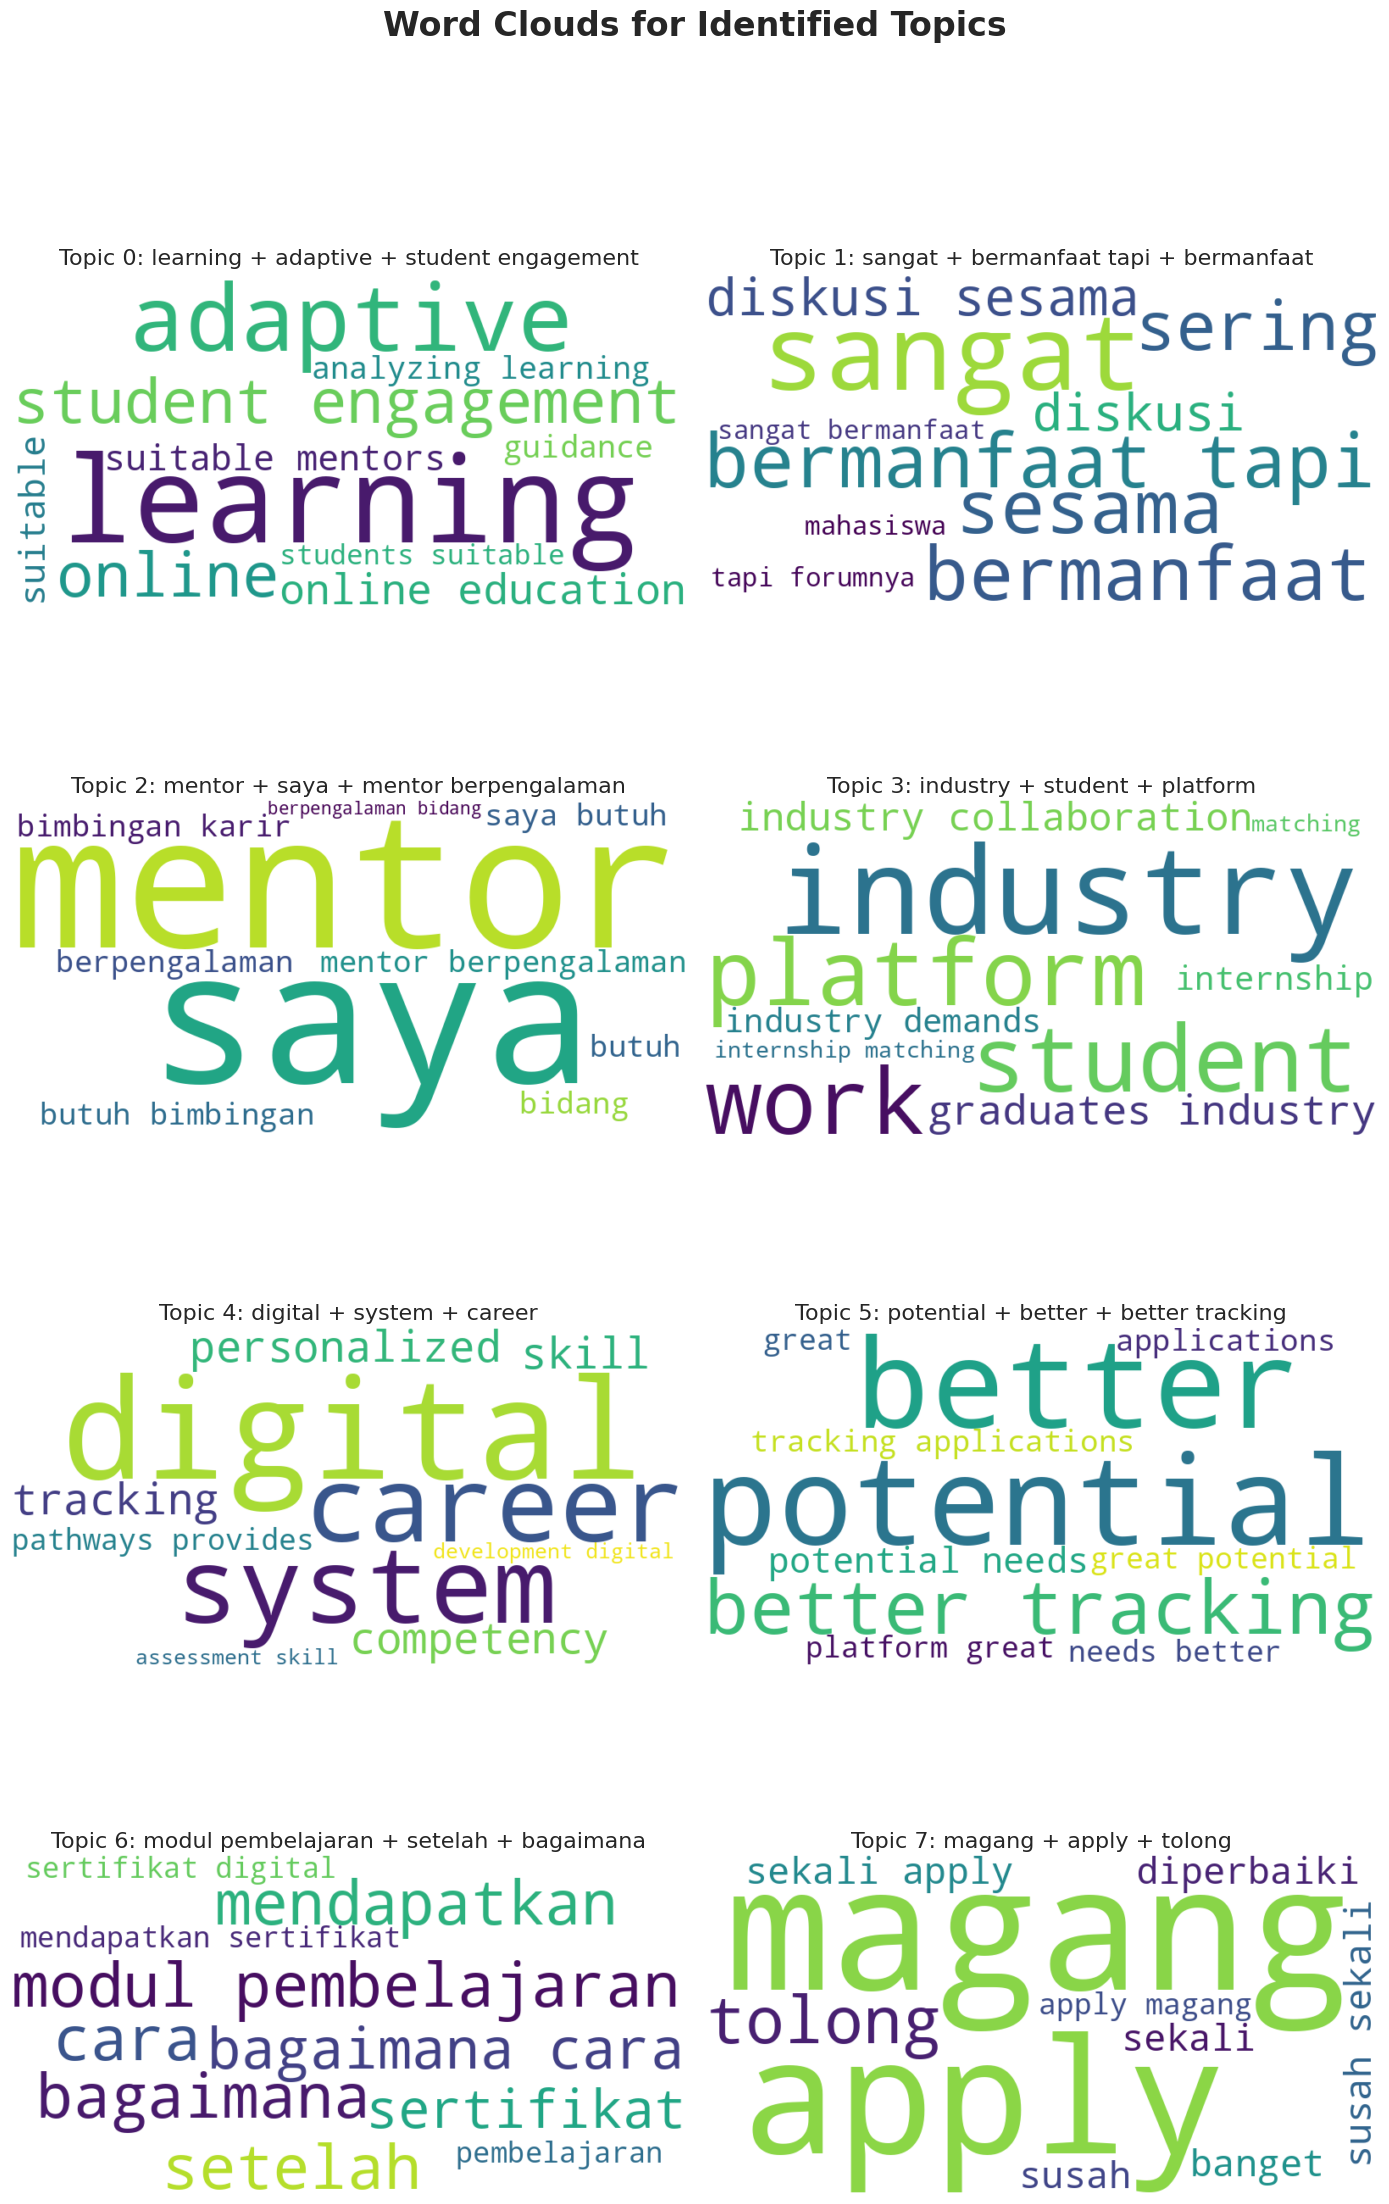

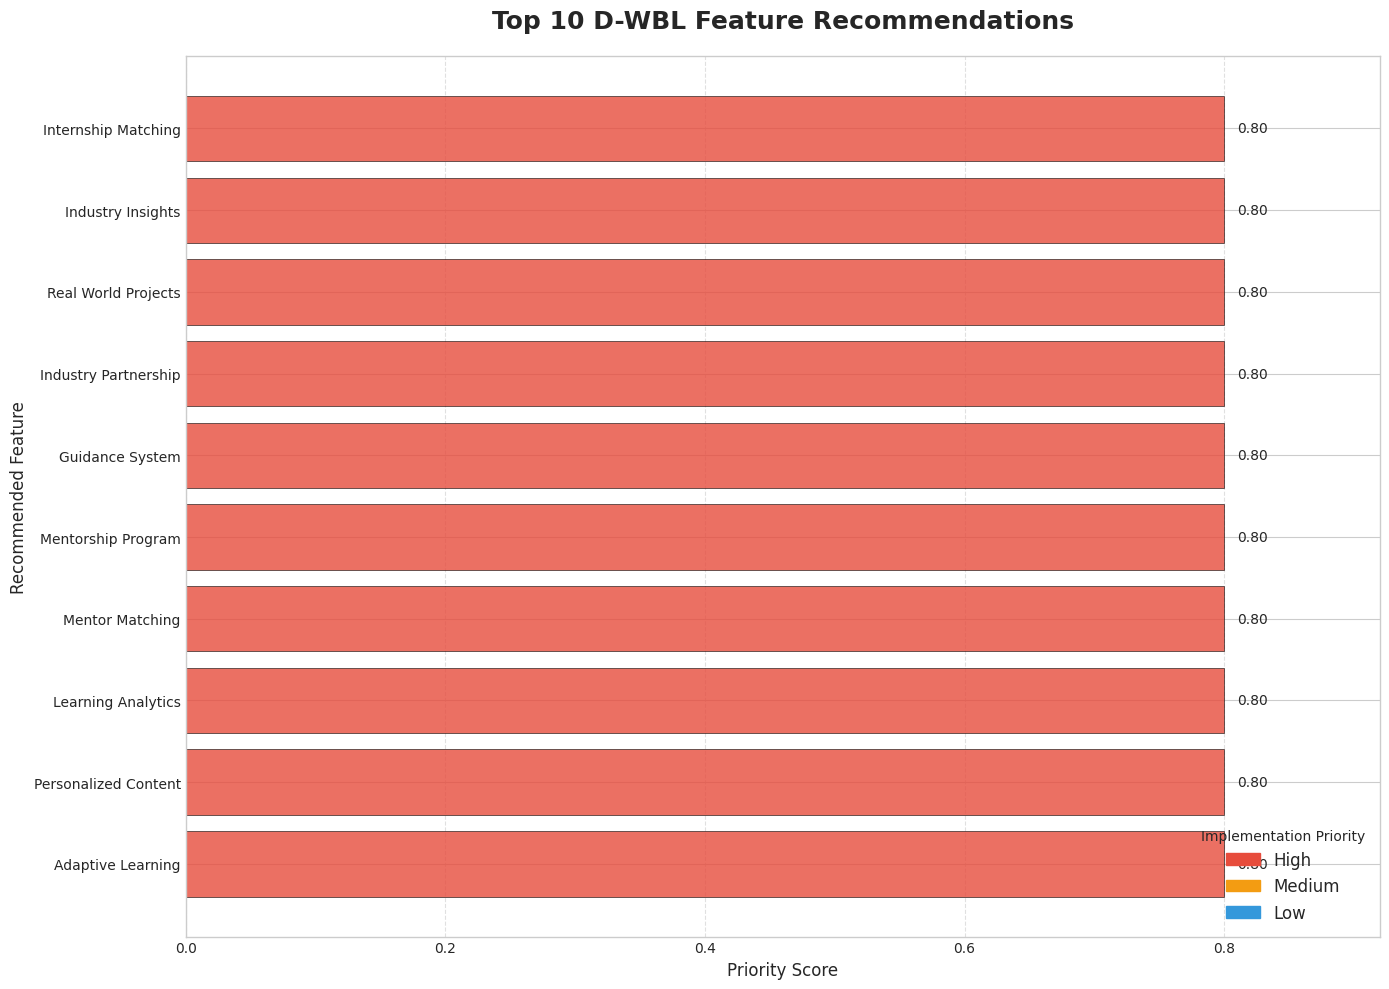

INFO:__main__:Analysis complete. Check for generated PNG files: sentiment_analysis.png, topic_word_clouds.png, feature_recommendations.png


In [8]:
import pandas as pd
import numpy as np
import json
import re
from datetime import datetime
from typing import List, Dict, Tuple, Optional
import logging
from dataclasses import dataclass, asdict
from collections import Counter, defaultdict

# ML and NLP libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.patches as mpatches


# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@dataclass
class MLInsight:
    """Data class untuk insight ML"""
    insight_type: str
    confidence: float
    description: str
    supporting_data: Dict
    recommendation: str

class TextPreprocessor:
    """
    Preprocessor untuk teks Indonesia dan Inggris
    """
    
    def __init__(self):
        # Download NLTK data
        self._download_nltk_data()
        
        # Indonesian stopwords
        self.indonesian_stopwords = set([
            'yang', 'di', 'ke', 'dari', 'untuk', 'dengan', 'pada', 'dalam', 
            'adalah', 'ini', 'itu', 'dan', 'atau', 'juga', 'akan', 'sudah',
            'telah', 'dapat', 'bisa', 'tidak', 'jangan', 'seperti', 'karena',
            'sebagai', 'oleh', 'terhadap', 'agar', 'supaya', 'sehingga'
        ])
        
        # English stopwords
        try:
            self.english_stopwords = set(stopwords.words('english'))
        except LookupError:
            # Fallback English stopwords
            self.english_stopwords = set([
                'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
                'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
                'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could',
                'should', 'may', 'might', 'must', 'can', 'this', 'that', 'these',
                'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him',
                'her', 'us', 'them', 'my', 'your', 'his', 'her', 'its', 'our', 'their'
            ])
        
        # Combined stopwords
        self.all_stopwords = self.indonesian_stopwords.union(self.english_stopwords)
        
        # Stemmer
        self.stemmer = PorterStemmer()
        
        # Sentiment analyzer
        try:
            self.sentiment_analyzer = SentimentIntensityAnalyzer()
        except LookupError:
            logger.warning("VADER sentiment analyzer not available, using basic sentiment analysis")
            self.sentiment_analyzer = None
    
    def _download_nltk_data(self):
        """Download required NLTK data"""
        required_data = [
            ('punkt', 'tokenizers/punkt'),
            ('stopwords', 'corpora/stopwords'),
            ('vader_lexicon', 'sentiment/vader_lexicon.zip/vader_lexicon/vader_lexicon.txt')
        ]
        
        for name, path in required_data:
            try:
                nltk.data.find(path)
            except LookupError:
                try:
                    nltk.download(name, quiet=True)
                    logger.info(f"Downloaded {name}")
                except Exception as e:
                    logger.warning(f"Could not download {name}: {e}")
    
    def clean_text(self, text: str) -> str:
        """Clean and normalize text"""
        if not isinstance(text, str):
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
        
        # Remove mentions and hashtags
        text = re.sub(r'@\w+|#\w+', '', text)
        
        # Remove special characters but keep spaces
        text = re.sub(r'[^\w\s]', ' ', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def tokenize_and_filter(self, text: str) -> List[str]:
        """Tokenize text and filter stopwords"""
        if not text:
            return []
        
        try:
            tokens = word_tokenize(text)
        except LookupError:
            # Fallback tokenization
            tokens = text.split()
        
        # Filter tokens
        filtered_tokens = [
            token for token in tokens
            if token.isalpha() and len(token) > 2 and token not in self.all_stopwords
        ]
        
        return filtered_tokens
    
    def preprocess_batch(self, texts: List[str]) -> List[List[str]]:
        """Preprocess batch of texts"""
        processed_texts = []
        
        for text in texts:
            cleaned = self.clean_text(text)
            tokens = self.tokenize_and_filter(cleaned)
            processed_texts.append(tokens)
            
        return processed_texts

class SentimentAnalyzer:
    """
    Analyzer untuk sentimen teks
    """
    
    def __init__(self):
        self.preprocessor = TextPreprocessor()
        
        # Indonesian positive/negative words
        self.indonesian_positive = set([
            'bagus', 'baik', 'hebat', 'mantap', 'keren', 'senang', 'suka', 
            'membantu', 'berguna', 'efektif', 'efisien', 'mudah', 'praktis',
            'inovatif', 'canggih', 'modern', 'terbaik', 'sempurna', 'luar biasa',
            'excellent', 'good', 'great', 'amazing', 'wonderful', 'fantastic',
            'perfect', 'awesome', 'brilliant', 'outstanding'
        ])
        
        self.indonesian_negative = set([
            'buruk', 'jelek', 'susah', 'sulit', 'ribet', 'kecewa', 'bingung',
            'lambat', 'lelet', 'error', 'bermasalah', 'tidak', 'kurang', 'gagal',
            'rusak', 'lemot', 'terburuk', 'parah', 'hancur', 'payah',
            'bad', 'terrible', 'awful', 'horrible', 'poor', 'disappointing',
            'frustrating', 'confusing', 'difficult', 'problematic'
        ])
    
    def analyze_sentiment(self, text: str) -> Dict:
        """Analyze sentiment of text"""
        if not text:
            return {
                'sentiment_score': 0,
                'sentiment_label': 'neutral',
                'positive_words': 0,
                'negative_words': 0,
                'vader_scores': {'compound': 0, 'pos': 0, 'neu': 1, 'neg': 0},
                'confidence': 0
            }
        
        # Clean text
        cleaned_text = self.preprocessor.clean_text(text)
        tokens = self.preprocessor.tokenize_and_filter(cleaned_text)
        
        # Count positive/negative words
        positive_count = sum(1 for token in tokens if token in self.indonesian_positive)
        negative_count = sum(1 for token in tokens if token in self.indonesian_negative)
        
        # Calculate sentiment score
        total_sentiment_words = positive_count + negative_count
        if total_sentiment_words > 0:
            sentiment_score = (positive_count - negative_count) / total_sentiment_words
        else:
            sentiment_score = 0
        
        # Use VADER for English text if available
        vader_scores = {'compound': 0, 'pos': 0, 'neu': 1, 'neg': 0}
        if self.preprocessor.sentiment_analyzer:
            try:
                vader_scores = self.preprocessor.sentiment_analyzer.polarity_scores(text)
            except:
                pass
        
        # Combine scores
        combined_score = (sentiment_score + vader_scores['compound']) / 2
        
        # Classify sentiment
        if combined_score >= 0.1:
            sentiment_label = 'positive'
        elif combined_score <= -0.1:
            sentiment_label = 'negative'
        else:
            sentiment_label = 'neutral'
        
        return {
            'sentiment_score': combined_score,
            'sentiment_label': sentiment_label,
            'positive_words': positive_count,
            'negative_words': negative_count,
            'vader_scores': vader_scores,
            'confidence': abs(combined_score)
        }
    
    def analyze_batch(self, texts: List[str]) -> List[Dict]:
        """Analyze sentiment for batch of texts"""
        results = []
        for text in texts:
            result = self.analyze_sentiment(text)
            results.append(result)
        return results

class TopicModeler:
    """
    Topic modeling menggunakan LDA dan clustering
    """
    
    def __init__(self, n_topics: int = 5):
        self.n_topics = n_topics
        self.preprocessor = TextPreprocessor()
        self.vectorizer = None
        self.lda_model = None
        self.kmeans_model = None
        
    def fit_lda(self, texts: List[str]) -> Dict:
        """Fit LDA model untuk topic modeling"""
        # Filter out empty texts
        texts = [text for text in texts if text and text.strip()]
        
        if not texts:
            return {
                'topics': [],
                'doc_topic_probabilities': np.array([]),
                'coherence_score': 0
            }
        
        # Preprocess texts
        processed_texts = []
        for text in texts:
            cleaned = self.preprocessor.clean_text(text)
            tokens = self.preprocessor.tokenize_and_filter(cleaned)
            if tokens:  # Only add non-empty token lists
                processed_texts.append(' '.join(tokens))
        
        if not processed_texts:
            return {
                'topics': [],
                'doc_topic_probabilities': np.array([]),
                'coherence_score': 0
            }
        
        # Create document-term matrix
        self.vectorizer = CountVectorizer(
            max_features=1000,
            min_df=1,  # Reduced from 2 to handle small datasets
            max_df=0.8,
            ngram_range=(1, 2)
        )
        
        doc_term_matrix = self.vectorizer.fit_transform(processed_texts)
        
        # Adjust n_topics based on available documents and features
        actual_n_topics = min(self.n_topics, len(processed_texts), doc_term_matrix.shape[1])
        if actual_n_topics == 0:
            return {
                'topics': [], 'doc_topic_probabilities': np.array([]), 'coherence_score': 0
            }
        
        # Fit LDA model
        self.lda_model = LatentDirichletAllocation(
            n_components=actual_n_topics,
            random_state=42,
            max_iter=20
        )
        
        self.lda_model.fit(doc_term_matrix)
        
        # Extract topics
        topics = self._extract_topics()
        
        # Get document-topic probabilities
        doc_topic_probs = self.lda_model.transform(doc_term_matrix)
        
        return {
            'topics': topics,
            'doc_topic_probabilities': doc_topic_probs,
            'coherence_score': self._calculate_coherence_score(doc_term_matrix)
        }
    
    def _extract_topics(self) -> List[Dict]:
        """Extract topics from fitted LDA model"""
        if not self.lda_model or not self.vectorizer:
            return []
        
        feature_names = self.vectorizer.get_feature_names_out()
        topics = []
        
        for topic_idx, topic in enumerate(self.lda_model.components_):
            top_words_idx = topic.argsort()[-10:][::-1]
            top_words = [(feature_names[i], topic[i]) for i in top_words_idx]
            
            topics.append({
                'topic_id': topic_idx,
                'top_words': top_words,
                'topic_label': self._generate_topic_label(top_words)
            })
        
        return topics
    
    def _generate_topic_label(self, top_words: List[Tuple[str, float]]) -> str:
        """Generate human-readable topic label"""
        # Simple heuristic: use top 3 words
        top_3_words = [word for word, _ in top_words[:3]]
        return ' + '.join(top_3_words)
    
    def _calculate_coherence_score(self, doc_term_matrix) -> float:
        """Calculate topic coherence score (log-likelihood)"""
        try:
            return self.lda_model.score(doc_term_matrix)
        except:
            return 0.0
    
    def predict_topics(self, texts: List[str]) -> List[int]:
        """Predict topics for new texts"""
        if not self.lda_model or not self.vectorizer:
            raise ValueError("Model not fitted yet")
        
        processed_texts = []
        for text in texts:
            cleaned = self.preprocessor.clean_text(text)
            tokens = self.preprocessor.tokenize_and_filter(cleaned)
            processed_texts.append(' '.join(tokens))
        
        doc_term_matrix = self.vectorizer.transform(processed_texts)
        doc_topic_probs = self.lda_model.transform(doc_term_matrix)
        
        # Get dominant topic for each document
        predicted_topics = doc_topic_probs.argmax(axis=1)
        
        return predicted_topics.tolist()

class FeatureRecommender:
    """
    ML-based feature recommender untuk aplikasi D-WBL
    """
    
    def __init__(self):
        self.sentiment_analyzer = SentimentAnalyzer()
        self.topic_modeler = TopicModeler(n_topics=8)
        self.feature_mapping = self._create_feature_mapping()
        
    def _create_feature_mapping(self) -> Dict:
        """Create mapping between topics/keywords and app features"""
        return {
            'magang': {
                'features': ['internship_matching', 'company_directory', 'application_tracker'],
                'priority': 'high',
                'description': 'Sistem pencarian dan pendaftaran magang'
            },
            'mentor': {
                'features': ['mentor_matching', 'mentorship_program', 'guidance_system'],
                'priority': 'high',
                'description': 'Program mentorship dengan industri'
            },
            'skill': {
                'features': ['skill_assessment', 'learning_modules', 'competency_tracking'],
                'priority': 'medium',
                'description': 'Pengembangan dan penilaian kompetensi'
            },
            'karir': {
                'features': ['career_guidance', 'job_matching', 'career_pathway'],
                'priority': 'high',
                'description': 'Panduan dan perencanaan karir'
            },
            'digital': {
                'features': ['digital_portfolio', 'online_learning', 'digital_certification'],
                'priority': 'medium',
                'description': 'Platform pembelajaran dan sertifikasi digital'
            },
            'komunikasi': {
                'features': ['communication_tools', 'peer_networking', 'discussion_forum'],
                'priority': 'medium',
                'description': 'Tools komunikasi dan networking'
            },
            'evaluasi': {
                'features': ['progress_tracking', 'performance_analytics', 'feedback_system'],
                'priority': 'medium',
                'description': 'Sistem evaluasi dan tracking progress'
            },
            'sertifikat': {
                'features': ['certification_system', 'blockchain_certificates', 'skill_badges'],
                'priority': 'low',
                'description': 'Sistem sertifikasi dan pengakuan kompetensi'
            },
            'learning': {
                'features': ['adaptive_learning', 'personalized_content', 'learning_analytics'],
                'priority': 'high',
                'description': 'Sistem pembelajaran adaptif'
            },
            'industry': {
                'features': ['industry_partnership', 'real_world_projects', 'industry_insights'],
                'priority': 'high',
                'description': 'Kolaborasi dengan industri'
            }
        }
    
    def analyze_user_needs(self, social_media_data: List[Dict], journal_data: List[Dict]) -> Dict:
        """Analyze user needs from social media and journal data"""
        # Combine all text data
        all_texts = []
        
        # Extract social media texts
        for post in social_media_data:
            content = post.get('content', '')
            if content:
                all_texts.append(content)
        
        # Extract journal abstracts
        for article in journal_data:
            abstract = article.get('abstract', '')
            if abstract:
                all_texts.append(abstract)
        
        if not all_texts:
            # Return empty results if no text data
            return {
                'sentiment_analysis': self._summarize_sentiment([]),
                'topic_analysis': {'topics': [], 'doc_topic_probabilities': np.array([]), 'coherence_score': 0},
                'key_insights': [],
                'feature_recommendations': self._generate_feature_recommendations([])
            }
        
        # Sentiment analysis
        sentiment_results = self.sentiment_analyzer.analyze_batch(all_texts)
        
        # Topic modeling
        topic_results = self.topic_modeler.fit_lda(all_texts)
        
        # Extract key insights
        insights = self._extract_insights(sentiment_results, topic_results, all_texts)
        
        return {
            'sentiment_analysis': self._summarize_sentiment(sentiment_results),
            'topic_analysis': topic_results,
            'key_insights': [asdict(i) for i in insights],
            'feature_recommendations': self._generate_feature_recommendations(insights)
        }
    
    def _extract_insights(self, sentiment_results: List[Dict], topic_results: Dict, texts: List[str]) -> List[MLInsight]:
        """Extract actionable insights from analysis"""
        insights = []
        
        if not sentiment_results:
            return insights
        
        # Sentiment insights
        summary = self._summarize_sentiment(sentiment_results)
        negative_ratio = summary['negative_ratio']
        
        if negative_ratio > 0.3:
            insights.append(MLInsight(
                insight_type='sentiment_pain_point',
                confidence=negative_ratio,
                description=f'Tingkat keluhan tinggi ({negative_ratio:.1%}) mengindikasikan adanya pain points signifikan.',
                supporting_data={'negative_ratio': negative_ratio, 'sample_complaints': self._get_negative_samples(texts, sentiment_results)},
                recommendation='Prioritaskan fitur yang mengatasi keluhan utama pengguna (misal: performa lambat, proses sulit).'
            ))
        
        # Topic insights
        for topic in topic_results.get('topics', []):
            topic_words = [word for word, _ in topic['top_words'][:5]]
            
            # Check if topic relates to app features
            for keyword, feature_info in self.feature_mapping.items():
                if any(keyword in word for word in topic['topic_label'].split(' + ')):
                    insights.append(MLInsight(
                        insight_type='topic_need',
                        confidence=0.8, # Static confidence for topic match
                        description=f'Topik "{topic["topic_label"]}" menunjukkan kebutuhan kuat akan {feature_info["description"]}.',
                        supporting_data={'topic_words': topic_words, 'feature_mapping': feature_info},
                        recommendation=f'Kembangkan atau tingkatkan fitur terkait: {", ".join(feature_info["features"])}.'
                    ))
                    # Break after first match to avoid multiple insights for the same topic
                    break
        
        return insights
    
    def _get_negative_samples(self, texts: List[str], sentiment_results: List[Dict]) -> List[str]:
        """Get sample negative texts"""
        negative_samples = []
        for i, result in enumerate(sentiment_results):
            if result['sentiment_label'] == 'negative' and len(negative_samples) < 5:
                negative_samples.append(texts[i][:150] + '...')
        return negative_samples
    
    def _summarize_sentiment(self, sentiment_results: List[Dict]) -> Dict:
        """Summarize sentiment analysis results"""
        if not sentiment_results:
            return {
                'total_analyzed': 0, 'positive_count': 0, 'negative_count': 0, 'neutral_count': 0,
                'positive_ratio': 0, 'negative_ratio': 0, 'neutral_ratio': 0,
                'average_sentiment_score': 0, 'overall_sentiment': 'neutral'
            }
        
        total = len(sentiment_results)
        positive = len([s for s in sentiment_results if s['sentiment_label'] == 'positive'])
        negative = len([s for s in sentiment_results if s['sentiment_label'] == 'negative'])
        neutral = total - positive - negative
        
        avg_score = np.mean([s['sentiment_score'] for s in sentiment_results])
        
        return {
            'total_analyzed': total,
            'positive_count': positive, 'negative_count': negative, 'neutral_count': neutral,
            'positive_ratio': positive / total, 'negative_ratio': negative / total, 'neutral_ratio': neutral / total,
            'average_sentiment_score': avg_score,
            'overall_sentiment': 'positive' if avg_score > 0.1 else 'negative' if avg_score < -0.1 else 'neutral'
        }
    
    def _generate_feature_recommendations(self, insights: List[MLInsight]) -> List[Dict]:
        """Generate feature recommendations based on insights"""
        feature_scores = defaultdict(float)
        feature_evidence = defaultdict(list)
        
        # Score features based on insights
        for insight in insights:
            if insight.insight_type == 'topic_need':
                feature_info = insight.supporting_data.get('feature_mapping', {})
                features = feature_info.get('features', [])
                priority = feature_info.get('priority', 'medium')
                
                # Priority scoring
                priority_score = {'high': 1.0, 'medium': 0.7, 'low': 0.4}
                score = priority_score.get(priority, 0.5) * insight.confidence
                
                for feature in features:
                    feature_scores[feature] += score
                    feature_evidence[feature].append(insight.description)
        
        # Add baseline recommendations if no specific insights or to augment existing ones
        baseline_features = [
            ('internship_matching', 0.8), ('mentor_matching', 0.75), ('skill_assessment', 0.6),
            ('career_guidance', 0.7), ('digital_portfolio', 0.5)
        ]
        for feature, score in baseline_features:
            if feature not in feature_scores:
                feature_scores[feature] = score
                feature_evidence[feature].append('Rekomendasi dasar berdasarkan kebutuhan umum D-WBL.')
        
        # Sort features by score
        sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
        
        # Generate recommendations
        recommendations = []
        for feature, score in sorted_features[:10]:  # Top 10 features
            recommendations.append({
                'feature_name': feature.replace('_', ' ').title(),
                'priority_score': score,
                'evidence': list(set(feature_evidence[feature])), # Remove duplicate evidence
                'implementation_priority': 'High' if score >= 0.8 else 'Medium' if score > 0.5 else 'Low'
            })
        
        return recommendations

class MLVisualizer:
    """
    Visualizer untuk hasil ML analysis
    """
    
    def __init__(self):
        try:
            plt.style.use('seaborn-v0_8-whitegrid')
        except:
            plt.style.use('default')
        sns.set_palette('viridis')
        
    def plot_sentiment_distribution(self, sentiment_summary: Dict):
        """Plot distribusi sentimen"""
        plt.figure(figsize=(15, 6))
        
        # Pie chart
        ax1 = plt.subplot(1, 2, 1)
        labels = ['Positive', 'Negative', 'Neutral']
        sizes = [
            sentiment_summary['positive_count'],
            sentiment_summary['negative_count'],
            sentiment_summary['neutral_count']
        ]
        colors = ['#2ecc71', '#e74c3c', '#95a5a6']
        
        if sum(sizes) > 0:
            ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140,
                    wedgeprops={'edgecolor': 'white', 'linewidth': 1})
            ax1.set_title('Sentiment Distribution', fontsize=16, pad=20)
        else:
            ax1.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=14, transform=ax1.transAxes)
        
        # Bar chart
        ax2 = plt.subplot(1, 2, 2)
        if sum(sizes) > 0:
            sns.barplot(x=labels, y=sizes, palette=colors, ax=ax2)
            ax2.set_title('Sentiment Counts', fontsize=16, pad=20)
            ax2.set_ylabel('Number of Texts', fontsize=12)
            ax2.bar_label(ax2.containers[0], fontsize=10)
        else:
            ax2.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=14, transform=ax2.transAxes)

        plt.suptitle('Overall Sentiment Analysis', fontsize=20, weight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig('sentiment_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_word_cloud_for_topics(self, topic_results: Dict):
        """Plot word clouds for each topic"""
        topics = topic_results.get('topics', [])
        if not topics:
            logger.warning("No topics to visualize in a word cloud.")
            return

        num_topics = len(topics)
        cols = 2
        rows = (num_topics + 1) // cols
        plt.figure(figsize=(7 * cols, 6 * rows))

        for i, topic in enumerate(topics):
            ax = plt.subplot(rows, cols, i + 1)
            word_freq = {word: score for word, score in topic['top_words']}
            wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_freq)
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.set_title(f'Topic {i}: {topic["topic_label"]}', fontsize=16)
            ax.axis('off')
        
        plt.suptitle('Word Clouds for Identified Topics', fontsize=24, weight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig('topic_word_clouds.png', dpi=300, bbox_inches='tight')
        plt.show()

    def plot_feature_recommendations(self, recommendations: List[Dict]):
        """Plot rekomendasi fitur"""
        if not recommendations:
            fig, ax = plt.subplots(figsize=(12, 8))
            ax.text(0.5, 0.5, 'No Recommendations Available', ha='center', va='center', fontsize=14, transform=ax.transAxes)
            ax.set_title('Feature Recommendations', fontsize=16)
            plt.tight_layout()
            plt.savefig('feature_recommendations.png', dpi=300, bbox_inches='tight')
            plt.show()
            return
        
        plt.figure(figsize=(14, 10))
        
        # Prepare data
        df = pd.DataFrame(recommendations)
        df = df.sort_values('priority_score', ascending=True)

        features = df['feature_name']
        scores = df['priority_score']
        priorities = df['implementation_priority']
        
        # Color mapping
        color_map = {'High': '#e74c3c', 'Medium': '#f39c12', 'Low': '#3498db'}
        colors = [color_map[p] for p in priorities]
        
        # Create horizontal bar chart
        bars = plt.barh(features, scores, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Add score labels
        for bar in bars:
            plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                     f'{bar.get_width():.2f}', va='center', ha='left', fontsize=10)
        
        plt.xlabel('Priority Score', fontsize=12)
        plt.ylabel('Recommended Feature', fontsize=12)
        plt.title('Top 10 D-WBL Feature Recommendations', fontsize=18, weight='bold', pad=20)
        plt.xlim(0, max(scores) * 1.15)
        plt.grid(axis='x', linestyle='--', alpha=0.6)

        # Create legend
        legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
        plt.legend(handles=legend_patches, title='Implementation Priority', loc='lower right', fontsize=12)
        
        plt.tight_layout()
        plt.savefig('feature_recommendations.png', dpi=300, bbox_inches='tight')
        plt.show()

# Main execution block
if __name__ == '__main__':
    # --- 1. Simulate Input Data ---
    social_media_data = [
        {'content': 'Aplikasi ini sangat membantu saya mencari tempat magang, fiturnya keren! #magang #dwbl'},
        {'content': 'Sistemnya lambat banget, susah sekali apply magang. Tolong diperbaiki. #error'},
        {'content': 'Saya butuh bimbingan karir dan mentor yang berpengalaman di bidang IT.'},
        {'content': 'This platform has great potential but needs a better UI for tracking applications.'},
        {'content': 'Bagaimana cara mendapatkan sertifikat digital setelah menyelesaikan modul pembelajaran?'},
        {'content': 'Diskusi dengan sesama mahasiswa sangat bermanfaat, tapi forumnya sering down.'},
        {'content': 'Fitur pencocokan dengan industri sangat inovatif! Langsung dapat tawaran project.'},
        {'content': 'Kecewa, evaluasi dari mentor tidak jelas dan feedbacknya kurang membangun.'}
    ]

    journal_data = [
        {'abstract': 'This study explores the effectiveness of work-based learning (WBL) in bridging the skill gap between university graduates and industry demands. A digital platform for internship matching and industry collaboration is proposed to enhance student competency.'},
        {'abstract': 'The development of a digital portfolio is crucial for lifelong learning. We analyze the requirements for a competency assessment and skill tracking system that supports personalized career pathways and provides verifiable digital certification.'},
        {'abstract': 'Adaptive learning systems can significantly improve student engagement in online education. By analyzing learning patterns, the system can recommend personalized content and connect students with suitable mentors for career guidance.'}
    ]

    # --- 2. Run Analysis ---
    logger.info("Starting D-WBL Feature Recommendation Analysis...")
    recommender = FeatureRecommender()
    analysis_results = recommender.analyze_user_needs(social_media_data, journal_data)

    # --- 3. Print Results to Console ---
    print("\n" + "="*50)
    print("ANALYSIS RESULTS")
    print("="*50 + "\n")

    print("\n--- 1. Sentiment Analysis Summary ---")
    print(json.dumps(analysis_results['sentiment_analysis'], indent=2))

    print("\n--- 2. Topic Analysis ---")
    topics = analysis_results['topic_analysis'].get('topics', [])
    if topics:
        for topic in topics:
            print(f"  Topic {topic['topic_id']}: {topic['topic_label']}")
            top_words_str = ', '.join([w for w, s in topic['top_words'][:5]])
            print(f"    - Top Words: {top_words_str}")
    else:
        print("  No topics were identified.")

    print("\n--- 3. Key Insights ---")
    insights = analysis_results.get('key_insights', [])
    if insights:
        for i, insight in enumerate(insights):
            print(f"  Insight {i+1}: [{insight['insight_type']}] {insight['description']}")
            print(f"    - Recommendation: {insight['recommendation']}")
    else:
        print("  No key insights were generated.")

    print("\n--- 4. Feature Recommendations ---")
    recommendations = analysis_results.get('feature_recommendations', [])
    if recommendations:
        for i, rec in enumerate(recommendations):
            print(f"  {i+1}. {rec['feature_name']} (Score: {rec['priority_score']:.2f}, Priority: {rec['implementation_priority']})")
    else:
        print("  No features were recommended.")

    # --- 4. Generate Visualizations ---
    logger.info("\nGenerating visualizations...")
    visualizer = MLVisualizer()
    
    # Plot sentiment
    visualizer.plot_sentiment_distribution(analysis_results['sentiment_analysis'])
    
    # Plot topics
    visualizer.plot_word_cloud_for_topics(analysis_results['topic_analysis'])
    
    # Plot recommendations
    visualizer.plot_feature_recommendations(analysis_results['feature_recommendations'])

    logger.info("Analysis complete. Check for generated PNG files: sentiment_analysis.png, topic_word_clouds.png, feature_recommendations.png")

INFO:__main__:Mulai scraping TikTok...
INFO:__main__:Scraping TikTok untuk keyword: magang SMK
INFO:__main__:Scraping TikTok untuk keyword: lulusan SMK
INFO:__main__:Scraping TikTok untuk keyword: kompetensi digital
INFO:__main__:Scraping TikTok untuk keyword: kesiapan kerja
INFO:__main__:Scraping TikTok untuk keyword: industri 4.0
INFO:__main__:Scraping TikTok untuk keyword: pendidikan vokasi
INFO:__main__:Mulai scraping Twitter...
INFO:__main__:Scraping Twitter untuk keyword: magang SMK
INFO:__main__:Scraping Twitter untuk keyword: lulusan SMK
INFO:__main__:Scraping Twitter untuk keyword: kompetensi digital
INFO:__main__:Scraping Twitter untuk keyword: kesiapan kerja
INFO:__main__:Scraping Twitter untuk keyword: industri 4.0
INFO:__main__:Scraping Twitter untuk keyword: pendidikan vokasi
INFO:__main__:Analisis selesai! Hasil disimpan dalam social_media_research_results.json
INFO:__main__:Membuat visualisasi...



KESIMPULAN ANALISIS MEDIA SOSIAL

Berdasarkan analisis terhadap 96 post dari TikTok dan Twitter, ditemukan beberapa insight kunci untuk pengembangan aplikasi D-WBL:

1.  **Sentimen Utama**: Sentimen pembicaraan publik cenderung positif (31%), yang mengindikasikan antusiasme dan harapan terhadap solusi digital untuk pendidikan vokasi.
    Ini menunjukkan bahwa ada pasar yang 'lapar' akan solusi, tetapi solusi tersebut harus benar-benar menjawab 'pain points' yang ada.

2.  **Topik Pembahasan Utama**: Pembicaraan didominasi oleh kata kunci seperti 'industri', 'siswa', 'digital', dan 'magang'.
    -   **Industri & Siswa**: Kebutuhan akan platform yang mempermudah pencarian magang dan menghubungkan siswa dengan industri sangat tinggi.
    -   **Digital & Kompetensi**: Ada kesadaran kuat akan pentingnya 'skill digital' dan kompetensi yang relevan dengan Industri 4.0.
    -   **Mentor & Industri**: Peran mentor dan kolaborasi langsung dengan industri dianggap krusial untuk kesiapan kerja.



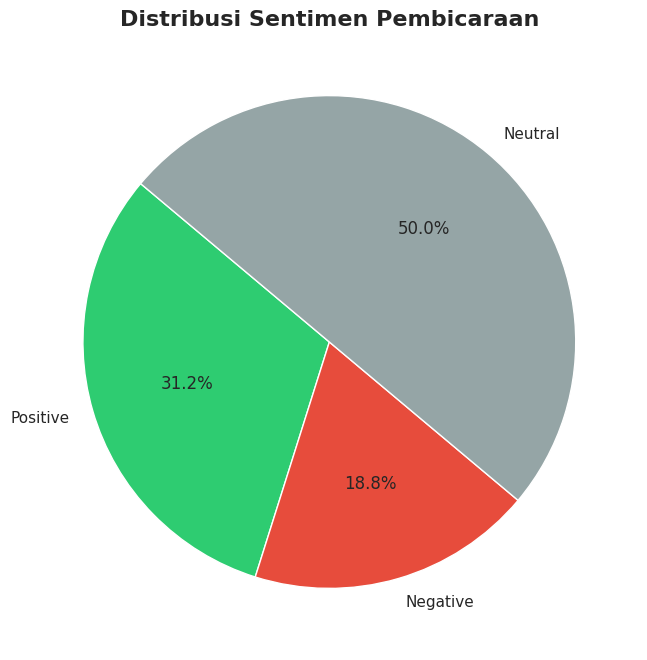

/tmp/ipykernel_2140/2650180863.py:267: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=keywords, palette='viridis', orient='h')


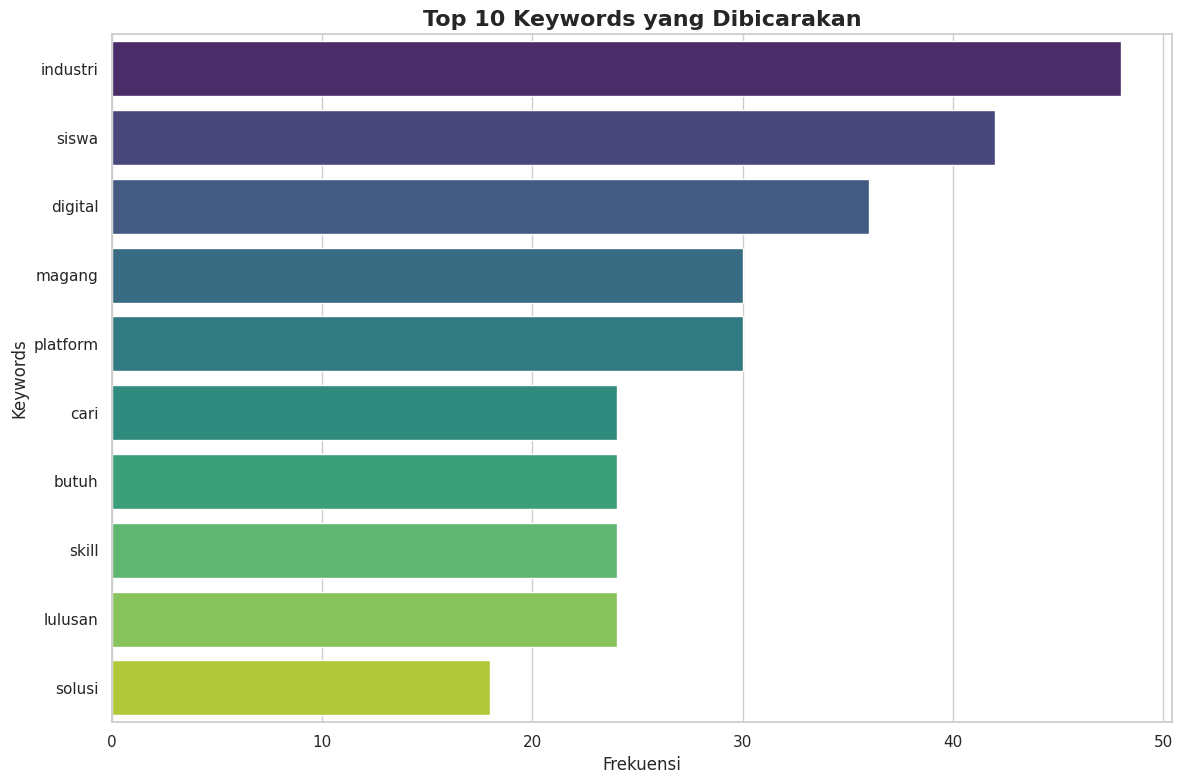

/tmp/ipykernel_2140/2650180863.py:280: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=sizes, palette='plasma')


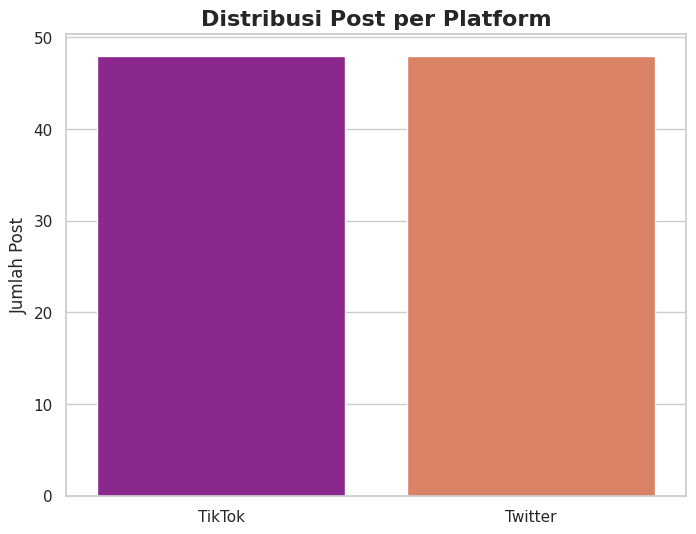

INFO:__main__:Visualisasi disimpan sebagai file PNG di direktori yang sama.


In [9]:
import requests
import pandas as pd
import json
import time
from datetime import datetime
import re
from typing import List, Dict, Optional
import logging
from dataclasses import dataclass, asdict
from collections import Counter

# Import library visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@dataclass
class SocialMediaPost:
    """Data class untuk menyimpan hasil scraping"""
    platform: str
    content: str
    author: str
    timestamp: datetime
    likes: int
    comments: int
    shares: int
    hashtags: List[str]
    mentions: List[str]

class TikTokScraper:
    """
    TikTok Scraper menggunakan Apify API
    Alternatif: bisa gunakan unofficial TikTok API
    """
    
    def __init__(self, apify_token: str = None):
        self.apify_token = apify_token
        self.base_url = "https://api.apify.com/v2"
        
    def search_posts(self, keywords: List[str], max_posts: int = 100) -> List[SocialMediaPost]:
        """
        Scraping TikTok posts berdasarkan keyword
        """
        posts = []
        if not keywords: return posts
        
        for keyword in keywords:
            logger.info(f"Scraping TikTok untuk keyword: {keyword}")
            
            # Simulasi data (replace dengan actual Apify call)
            sample_posts = self._simulate_tiktok_data(keyword, max_posts // len(keywords))
            posts.extend(sample_posts)
            
            time.sleep(1)  # Rate limiting
            
        return posts
    
    def _simulate_tiktok_data(self, keyword: str, count: int) -> List[SocialMediaPost]:
        """Simulasi data TikTok untuk testing"""
        posts = []
        sample_contents = [
            f"Susah banget cari tempat magang yang sesuai jurusan {keyword}, butuh solusi nih!",
            f"Buat platform yang bisa connect siswa SMK dengan industri dong, pasti berguna banget.",
            f"Skill digital penting banget buat lulusan SMK sekarang. Harus ada kurikulum yang relevan.",
            f"Mentor dari industri sangat membantu dalam mempersiapkan karier masa depan. #mentorship",
            f"Aplikasi seperti {keyword} bisa jadi solusi gap antara sekolah dan kebutuhan industri. Keren idenya!",
            f"Gimana caranya dapet sertifikasi resmi buat skill {keyword} yang kita pelajari sendiri?"
        ]
        
        for i in range(count):
            post = SocialMediaPost(
                platform="TikTok",
                content=sample_contents[i % len(sample_contents)],
                author=f"user_tiktok_{i}",
                timestamp=datetime.now(),
                likes=50 + i * 10,
                comments=5 + i * 2,
                shares=2 + i,
                hashtags=["#SMK", "#magang", "#karier", "#digital"],
                mentions=[]
            )
            posts.append(post)
            
        return posts

class TwitterScraper:
    """
    Twitter/X Scraper menggunakan snscrape atau Twitter API
    """
    
    def __init__(self, bearer_token: str = None):
        self.bearer_token = bearer_token
        self.headers = {
            "Authorization": f"Bearer {bearer_token}" if bearer_token else None
        }
    
    def search_posts(self, keywords: List[str], max_posts: int = 100) -> List[SocialMediaPost]:
        """
        Scraping Twitter posts berdasarkan keyword
        """
        posts = []
        if not keywords: return posts

        for keyword in keywords:
            logger.info(f"Scraping Twitter untuk keyword: {keyword}")
            
            # Simulasi data (replace dengan actual Twitter API call)
            sample_posts = self._simulate_twitter_data(keyword, max_posts // len(keywords))
            posts.extend(sample_posts)
            
            time.sleep(1)  # Rate limiting
            
        return posts
    
    def _simulate_twitter_data(self, keyword: str, count: int) -> List[SocialMediaPost]:
        """Simulasi data Twitter untuk testing"""
        posts = []
        sample_contents = [
            f"Pemerintah @kemdikbudristek perlu buat platform digital buat siswa SMK cari magang ({keyword}). Ini krusial!",
            f"Industri 4.0 butuh lulusan SMK yang punya skill digital mumpuni, bukan cuma teori.",
            f"Gap antara pendidikan SMK dan kebutuhan industri masih jadi PR besar. Kurikulum harus adaptif.",
            f"Mentorship program bisa bantu siswa SMK lebih siap kerja. Pengalaman dari praktisi itu mahal.",
            f"Teknologi blockchain bisa dipake buat verifikasi sertifikasi kompetensi siswa. Lebih terpercaya. #inovasi",
            f"Kurang platform buat kolaborasi proyek antara siswa SMK dan UMKM. Padahal potensinya besar."
        ]
        
        for i in range(count):
            post = SocialMediaPost(
                platform="Twitter",
                content=sample_contents[i % len(sample_contents)],
                author=f"@user_twitter_{i}",
                timestamp=datetime.now(),
                likes=20 + i * 5,
                comments=3 + i,
                shares=1 + i,
                hashtags=["#SMK", "#pendidikan", "#teknologi", "#linkandmatch"],
                mentions=["@kemdikbudristek"]
            )
            posts.append(post)
            
        return posts

class SocialMediaAnalyzer:
    """
    Analyzer untuk menganalisis hasil scraping
    """
    
    def __init__(self):
        self.posts = []
        self.stopwords = set([
            'yang', 'di', 'ke', 'dari', 'dan', 'atau', 'ini', 'itu', 'dengan', 'untuk', 'pada', 
            'adalah', 'bisa', 'buat', 'banget', 'bukan', 'cuma', 'dong', 'gimana', 'harus', 'jadi',
            'juga', 'kalau', 'kok', 'lagi', 'lebih', 'masih', 'mau', 'nih', 'sangat', 'saya', 'tapi',
            'the', 'a', 'is', 'to', 'in', 'for', 'of', 'it', 'be'
        ])
        
    def load_posts(self, posts: List[SocialMediaPost]):
        """Load posts untuk analisis"""
        self.posts = posts
        
    def extract_keywords(self) -> Dict[str, int]:
        """Extract keywords dari semua posts dengan filter stopwords"""
        keyword_count = Counter()
        
        for post in self.posts:
            words = re.findall(r'\b\w+\b', post.content.lower())
            for word in words:
                if len(word) > 3 and word not in self.stopwords and not word.isdigit():
                    keyword_count[word] += 1
                    
        return dict(keyword_count.most_common())
    
    def analyze_sentiment(self) -> Dict[str, float]:
        """
        Analisis sentimen sederhana. Diperbaiki untuk menghitung rasio netral.
        """
        positive_words = ['bagus', 'baik', 'membantu', 'berguna', 'senang', 'suka', 'keren', 'solusi', 'inovasi']
        negative_words = ['susah', 'sulit', 'buruk', 'jelek', 'kecewa', 'kurang', 'gap', 'masalah', 'pr']
        
        sentiment_scores = []
        pos_count_total, neg_count_total, neu_count_total = 0, 0, 0
        
        for post in self.posts:
            content = post.content.lower()
            pos_score = sum(1 for word in positive_words if word in content)
            neg_score = sum(1 for word in negative_words if word in content)
            
            if pos_score > neg_score:
                sentiment_scores.append(1)
                pos_count_total += 1
            elif neg_score > pos_score:
                sentiment_scores.append(-1)
                neg_count_total += 1
            else:
                sentiment_scores.append(0)
                neu_count_total += 1
        
        total_posts = len(self.posts)
        return {
            'average_sentiment': sum(sentiment_scores) / total_posts if total_posts else 0,
            'positive_ratio': pos_count_total / total_posts if total_posts else 0,
            'negative_ratio': neg_count_total / total_posts if total_posts else 0,
            'neutral_ratio': neu_count_total / total_posts if total_posts else 0
        }
    
    def get_insights(self) -> Dict:
        """Generate insights dari analisis"""
        if not self.posts:
            return {'error': 'No posts to analyze'}

        keywords = self.extract_keywords()
        sentiment = self.analyze_sentiment()
        
        return {
            'total_posts': len(self.posts),
            'top_keywords': dict(list(keywords.items())[:10]),
            'sentiment_analysis': sentiment,
            'platform_distribution': self._get_platform_distribution(),
            'engagement_stats': self._get_engagement_stats()
        }
    
    def _get_platform_distribution(self) -> Dict[str, int]:
        """Distribusi posts per platform"""
        return dict(Counter(post.platform for post in self.posts))
    
    def _get_engagement_stats(self) -> Dict:
        """Statistik engagement"""
        if not self.posts:
            return {}
            
        likes = [post.likes for post in self.posts]
        comments = [post.comments for post in self.posts]
        shares = [post.shares for post in self.posts]
        
        return {
            'avg_likes': sum(likes) / len(likes),
            'avg_comments': sum(comments) / len(comments),
            'avg_shares': sum(shares) / len(shares),
            'total_engagement': sum(likes) + sum(comments) + sum(shares)
        }

class DataVisualizer:
    """Kelas untuk membuat visualisasi dari data analisis"""
    def __init__(self):
        sns.set_theme(style="whitegrid", palette="viridis")

    def plot_sentiment_distribution(self, sentiment_data: Dict):
        labels = ['Positive', 'Negative', 'Neutral']
        sizes = [sentiment_data['positive_ratio'], sentiment_data['negative_ratio'], sentiment_data['neutral_ratio']]
        colors = ['#2ecc71', '#e74c3c', '#95a5a6']

        plt.figure(figsize=(8, 8))
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140,
                wedgeprops={'edgecolor': 'white', 'linewidth': 1})
        plt.title('Distribusi Sentimen Pembicaraan', fontsize=16, weight='bold')
        plt.savefig('sentiment_distribution.png', dpi=300)
        plt.show()

    def plot_top_keywords(self, keywords_data: Dict):
        keywords = list(keywords_data.keys())
        counts = list(keywords_data.values())
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x=counts, y=keywords, palette='viridis', orient='h')
        plt.title('Top 10 Keywords yang Dibicarakan', fontsize=16, weight='bold')
        plt.xlabel('Frekuensi', fontsize=12)
        plt.ylabel('Keywords', fontsize=12)
        plt.tight_layout()
        plt.savefig('top_keywords.png', dpi=300)
        plt.show()

    def plot_platform_distribution(self, platform_data: Dict):
        labels = list(platform_data.keys())
        sizes = list(platform_data.values())
        
        plt.figure(figsize=(8, 6))
        sns.barplot(x=labels, y=sizes, palette='plasma')
        plt.title('Distribusi Post per Platform', fontsize=16, weight='bold')
        plt.ylabel('Jumlah Post', fontsize=12)
        plt.savefig('platform_distribution.png', dpi=300)
        plt.show()

def generate_conclusion(insights: Dict) -> str:
    """Menghasilkan kesimpulan tekstual berdasarkan insight"""
    if 'error' in insights:
        return "Tidak ada data untuk dianalisis."

    sentiment = insights['sentiment_analysis']
    keywords = list(insights['top_keywords'].keys())

    # Interpretasi sentimen
    if sentiment['average_sentiment'] > 0.1:
        sentiment_summary = f"cenderung positif ({sentiment['positive_ratio']:.0%}), yang mengindikasikan antusiasme dan harapan terhadap solusi digital untuk pendidikan vokasi."
    elif sentiment['average_sentiment'] < -0.1:
        sentiment_summary = f"cenderung negatif ({sentiment['negative_ratio']:.0%}), menyoroti frustrasi dan masalah yang ada seperti sulitnya mencari magang dan gap kompetensi."
    else:
        sentiment_summary = "bersifat netral atau campuran. Ada harapan akan solusi, namun juga banyak keluhan tentang kondisi saat ini."

    conclusion = f"""
KESIMPULAN ANALISIS MEDIA SOSIAL
=====================================

Berdasarkan analisis terhadap {insights['total_posts']} post dari TikTok dan Twitter, ditemukan beberapa insight kunci untuk pengembangan aplikasi D-WBL:

1.  **Sentimen Utama**: Sentimen pembicaraan publik {sentiment_summary}
    Ini menunjukkan bahwa ada pasar yang 'lapar' akan solusi, tetapi solusi tersebut harus benar-benar menjawab 'pain points' yang ada.

2.  **Topik Pembahasan Utama**: Pembicaraan didominasi oleh kata kunci seperti '{keywords[0]}', '{keywords[1]}', '{keywords[2]}', dan '{keywords[3]}'.
    -   **{keywords[0].title()} & {keywords[1].title()}**: Kebutuhan akan platform yang mempermudah pencarian magang dan menghubungkan siswa dengan industri sangat tinggi.
    -   **{keywords[2].title()} & Kompetensi**: Ada kesadaran kuat akan pentingnya 'skill digital' dan kompetensi yang relevan dengan Industri 4.0.
    -   **Mentor & Industri**: Peran mentor dan kolaborasi langsung dengan industri dianggap krusial untuk kesiapan kerja.

3.  **Rekomendasi Strategis untuk Aplikasi D-WBL**:
    -   **Prioritaskan Fitur Inti**: Fokus utama harus pada fitur pencocokan magang (Internship Matching) yang cerdas dan direktori industri yang komprehensif.
    -   **Bangun Ekosistem Kompetensi**: Integrasikan fitur untuk penilaian skill (Skill Assessment), modul pembelajaran singkat (Micro-learning), dan program mentorship.
    -   **Validasi & Sertifikasi**: Pertimbangkan fitur portofolio digital dan sertifikasi yang terverifikasi (mungkin terinspirasi dari ide 'blockchain') untuk meningkatkan nilai jual lulusan.
    -   **Jawab 'Pain Points'**: Aplikasi harus dirancang untuk menjadi solusi atas 'kesulitan' dan 'gap' yang sering disebut, dengan antarmuka yang mudah digunakan.

Analisis ini mengkonfirmasi bahwa ada kebutuhan pasar yang jelas dan mendesak untuk platform seperti D-WBL. Keberhasilan akan bergantung pada kemampuan aplikasi untuk secara efektif menjadi jembatan antara dunia pendidikan dan industri.
"""
    return conclusion

def main():
    """Main function untuk menjalankan scraping, analisis, visualisasi, dan kesimpulan"""
    
    keywords = ["magang SMK", "lulusan SMK", "kompetensi digital", "kesiapan kerja", "industri 4.0", "pendidikan vokasi"]
    
    tiktok_scraper = TikTokScraper()
    twitter_scraper = TwitterScraper()
    
    logger.info("Mulai scraping TikTok...")
    tiktok_posts = tiktok_scraper.search_posts(keywords, max_posts=50)
    
    logger.info("Mulai scraping Twitter...")
    twitter_posts = twitter_scraper.search_posts(keywords, max_posts=50)
    
    all_posts = tiktok_posts + twitter_posts
    
    if not all_posts:
        logger.warning("Tidak ada post yang berhasil di-scrape. Program berhenti.")
        return

    analyzer = SocialMediaAnalyzer()
    analyzer.load_posts(all_posts)
    insights = analyzer.get_insights()
    
    # Generate Conclusion
    conclusion_text = generate_conclusion(insights)
    
    results = {
        'timestamp': datetime.now().isoformat(),
        'insights': insights,
        'conclusion': conclusion_text,
        'raw_posts': [asdict(post) for post in all_posts]
    }
    
    with open('social_media_research_results.json', 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False, default=str)
    
    logger.info("Analisis selesai! Hasil disimpan dalam social_media_research_results.json")
    
    # Print summary & conclusion
    print(conclusion_text)
    
    # Generate Visualizations
    logger.info("Membuat visualisasi...")
    visualizer = DataVisualizer()
    visualizer.plot_sentiment_distribution(insights['sentiment_analysis'])
    visualizer.plot_top_keywords(insights['top_keywords'])
    visualizer.plot_platform_distribution(insights['platform_distribution'])
    logger.info("Visualisasi disimpan sebagai file PNG di direktori yang sama.")
    
    return results

if __name__ == "__main__":
    main()

INFO:__main__:Checking/downloading NLTK resources...
INFO:__main__:NLTK resources are ready.
INFO:__main__:Simulating Google Scholar search for: 'work-based learning SMK Indonesia'
INFO:__main__:Simulating Portal Garuda search for: 'work-based learning SMK Indonesia'
INFO:__main__:Simulating Google Scholar search for: 'vocational education digital transformation'
INFO:__main__:Simulating Portal Garuda search for: 'vocational education digital transformation'
INFO:__main__:Simulating Google Scholar search for: 'industry 4.0 vocational training'
INFO:__main__:Simulating Portal Garuda search for: 'industry 4.0 vocational training'
INFO:__main__:Simulating Google Scholar search for: 'mentorship program vocational students'
INFO:__main__:Simulating Portal Garuda search for: 'mentorship program vocational students'
INFO:__main__:Simulating Google Scholar search for: 'mobile learning applications vocational'
INFO:__main__:Simulating Portal Garuda search for: 'mobile learning applications voca


      AUTOMATED LITERATURE REVIEW SUMMARY

[+] Total Unique Articles Analyzed: 75
[+] Publication Timeframe: 2018-2023

--- TOP THEMES & KEYWORDS ---
Top Themes (Phrases):
  1. Leveraging Machine
  2. Novel Framework
  3. Propose Novel
  4. Career Readiness
  5. Engagement Career

Top Keywords (Author-defined):
  1. Ai
  2. Mentorship
  3. Work-Based Learning
  4. Industry 4.0
  5. Vocational Education

--- RESEARCH GAPS IDENTIFIED ---
  - Lack of research on 'Blockchain' application in vocational education.
  - Lack of research on 'Virtual Reality' application in vocational education.
  - Limited focus on measurable 'Soft Skills' development frameworks.

--- DATA-DRIVEN RECOMMENDATIONS FOR D-WBL ---
  -> Develop a centralized digital platform for Work-Based Learning (WBL).
  -> Implement features for skill assessment and competency tracking.



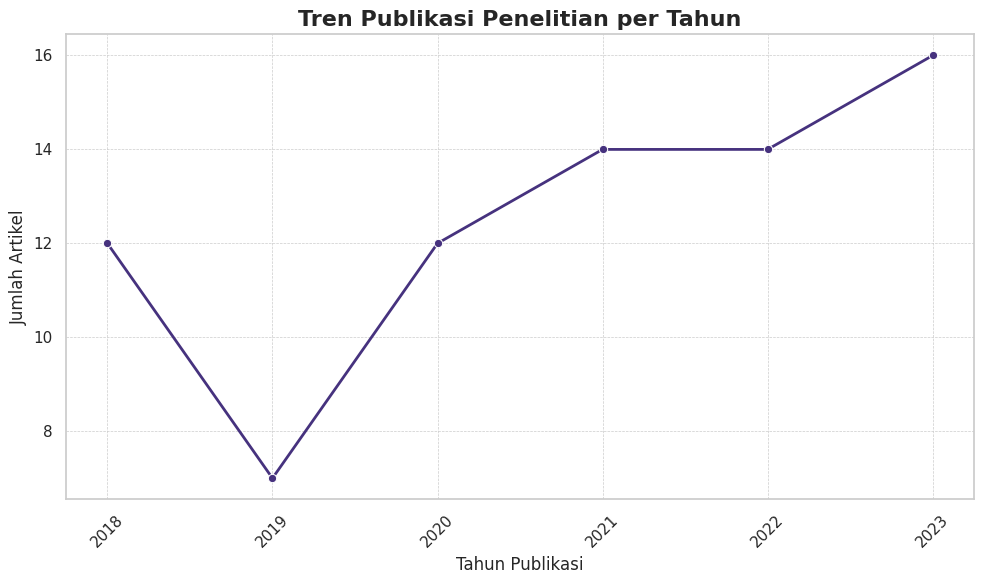

/tmp/ipykernel_2140/957165366.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=counts, y=entities, palette='viridis', orient='h')


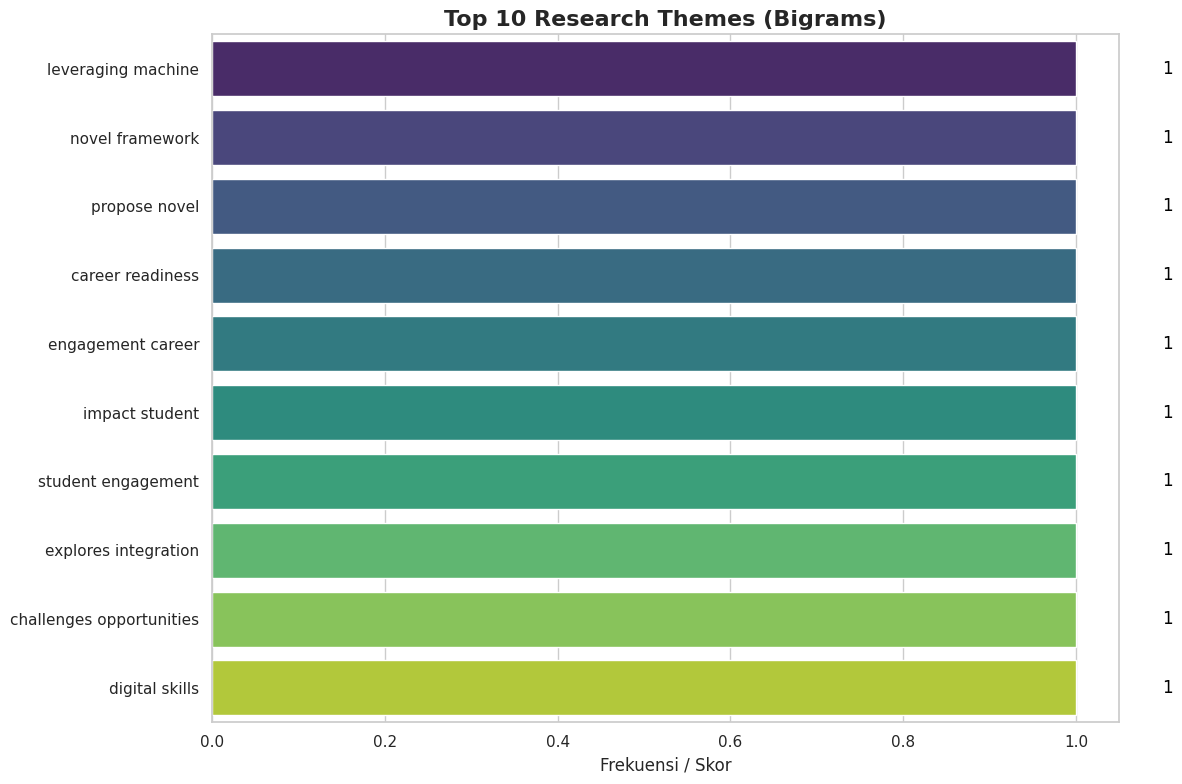

/tmp/ipykernel_2140/957165366.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=counts, y=entities, palette='viridis', orient='h')


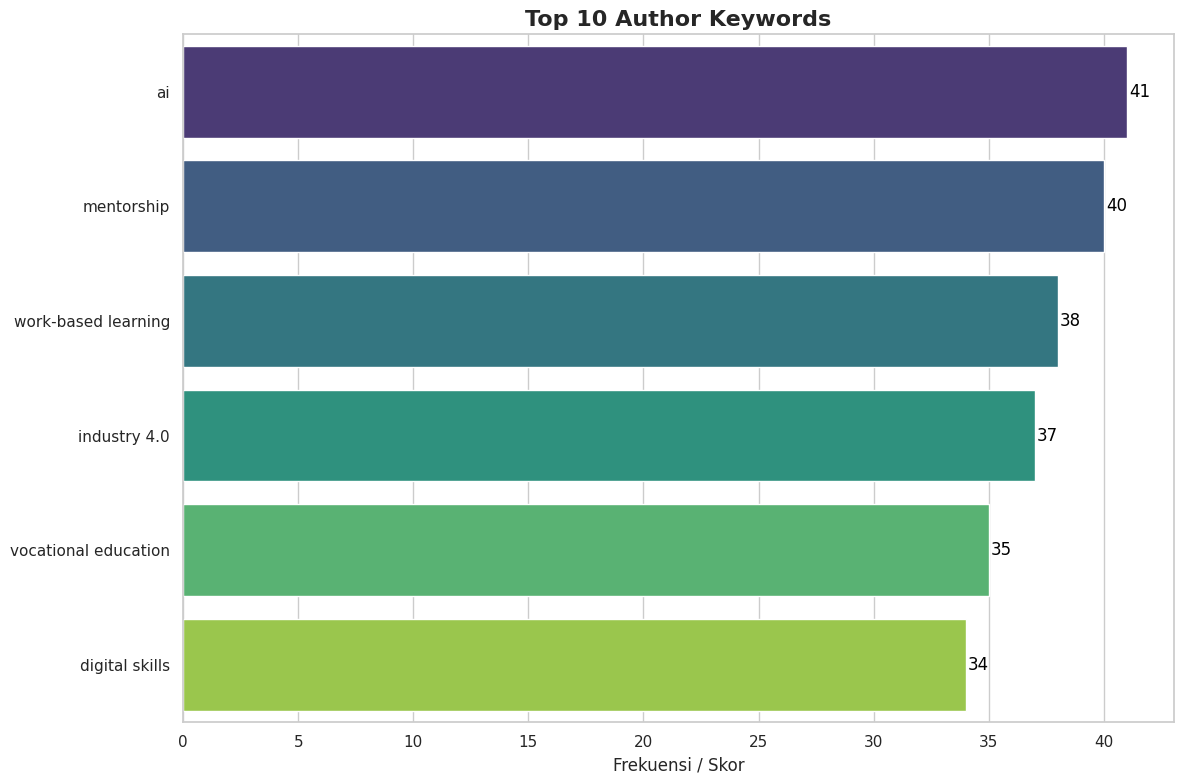

INFO:__main__:Literature review selesai! Hasil disimpan dalam 'literature_review_results.json' dan file PNG.


In [12]:
import requests
import pandas as pd
import json
import time
from datetime import datetime
from bs4 import BeautifulSoup
import re
from typing import List, Dict, Optional
import logging
from dataclasses import dataclass, asdict
from urllib.parse import urljoin, urlparse
import nltk
from nltk.corpus import stopwords
# --- MODIFIED IMPORT ---
# We import TreebankWordTokenizer directly to avoid the problematic sent_tokenize dependency
from nltk.tokenize import TreebankWordTokenizer
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# --- NLTK Data Download (Robust Version) ---
def download_nltk_data():
    """
    Downloads necessary NLTK data. This is idempotent (won't re-download if present).
    """
    try:
        logger.info("Checking/downloading NLTK resources...")
        nltk.download('punkt', quiet=True)
        nltk.download('stopwords', quiet=True)
        logger.info("NLTK resources are ready.")
    except Exception as e:
        logger.error(f"Failed to download NLTK data: {e}")
        logger.error("The program cannot continue. Please check your internet connection.")
        exit(1)

# Call the function at the start of the script
download_nltk_data()


@dataclass
class JournalArticle:
    """Data class untuk menyimpan artikel jurnal"""
    title: str
    authors: List[str]
    abstract: str
    keywords: List[str]
    publication_year: int
    journal_name: str
    doi: str
    url: str
    citation_count: int
    full_text: str = ""

    # Dunder methods for using in sets (for de-duplication)
    def __eq__(self, other):
        return self.doi == other.doi if self.doi else self.title.lower() == other.title.lower()

    def __hash__(self):
        return hash(self.doi) if self.doi else hash(self.title.lower())


class ScholarScraper:
    """
    Scraper untuk Google Scholar dan portal jurnal lainnya.
    """
    
    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        })
        
    def search_google_scholar(self, query: str, max_results: int = 10) -> List[JournalArticle]:
        """Scraping Google Scholar (simulasi)"""
        logger.info(f"Simulating Google Scholar search for: '{query}'")
        return self._simulate_scholar_data(query, max_results)
    
    def search_garuda_portal(self, query: str, max_results: int = 5) -> List[JournalArticle]:
        """Scraping Portal Garuda (simulasi)"""
        logger.info(f"Simulating Portal Garuda search for: '{query}'")
        return self._simulate_garuda_data(query, max_results)
    
    def _simulate_scholar_data(self, query: str, count: int) -> List[JournalArticle]:
        """Simulasi data Google Scholar yang lebih realistis."""
        articles = []
        titles = [
            "Digital Transformation in Vocational Education", "Work-Based Learning for Industry 4.0",
            "AI-Powered Career Guidance Systems", "Blockchain for Verifiable Credentials in Education",
            "Soft Skills Development via Digital Platforms", "Mobile Learning in Vocational Training",
            "Bridging the Gap: Industry-Academia Collaboration", "Readiness of Graduates for the Digital Economy"
        ]
        journals = ["Journal of Vocational Education & Training", "Computers & Education", "IEEE Transactions on Learning Technologies"]
        abstract_fragments = [
            "This study explores the integration of", "We propose a novel framework for", "An empirical analysis of",
            "the challenges and opportunities in", "its impact on student engagement and career readiness",
            "leveraging AI and machine learning to personalize", "the learning experience.", "the implementation of work-based learning"
        ]

        for i in range(count):
            year = random.randint(2018, 2023)
            article = JournalArticle(
                title=f"{random.choice(titles)}: A Case Study from {random.choice(['Indonesia', 'Southeast Asia'])}",
                authors=[f"Author A-{i}", f"Author B-{i}"],
                abstract=f"{random.choice(abstract_fragments)} {random.choice(abstract_fragments)}",
                keywords=random.sample(['vocational education', 'work-based learning', 'digital skills', 'AI', 'mentorship', 'industry 4.0'], k=3),
                publication_year=year,
                journal_name=random.choice(journals),
                doi=f"10.1234/j.{year}.{random.randint(100,999)}",
                url=f"https://example.com/article/{year}/{i+1}",
                citation_count=random.randint(5, 100)
            )
            articles.append(article)
        return articles
    
    def _simulate_garuda_data(self, query: str, count: int) -> List[JournalArticle]:
        """Simulasi data Portal Garuda."""
        return self._simulate_scholar_data(query, count)


class LiteratureAnalyzer:
    """Analyzer untuk literature review otomatis yang lebih cerdas."""
    
    def __init__(self):
        self.articles = []
        self.stop_words = set(stopwords.words('english') + stopwords.words('indonesian'))
        self.stop_words.update([
            'study', 'research', 'paper', 'article', 'method', 'results', 'conclusion',
            'introduction', 'background', 'abstract', 'keywords', 'data', 'analysis',
            'penelitian', 'studi', 'jurnal', 'artikel', 'metode', 'hasil', 'abstrak',
            'based', 'using', 'model', 'system', 'approach'
        ])
        # --- INSTANTIATE THE TOKENIZER ---
        self.tokenizer = TreebankWordTokenizer()

    def load_articles(self, articles: List[JournalArticle]):
        """Load articles dan hapus duplikat."""
        self.articles = list(set(articles))
        logger.info(f"Loaded {len(self.articles)} unique articles for analysis.")
        
    def extract_key_themes(self, top_n=20) -> Dict[str, int]:
        """Extract tema utama menggunakan bigrams (frasa 2 kata)."""
        all_text = " ".join([a.abstract for a in self.articles] + [k for a in self.articles for k in a.keywords])
        
        # --- USE THE DIRECT TOKENIZER ---
        # This call is more robust and avoids the LookupError.
        tokens = self.tokenizer.tokenize(all_text.lower())
        
        words = [w for w in tokens if w.isalpha() and w not in self.stop_words and len(w) > 2]
        
        finder = BigramCollocationFinder.from_words(words)
        finder.apply_freq_filter(2)
        bigram_measures = BigramAssocMeasures()
        
        top_bigrams = finder.nbest(bigram_measures.pmi, top_n)
        
        # Correctly count the frequency of the found top bigrams within the text
        theme_counts = Counter([' '.join(bigram) for bigram in top_bigrams])
        
        return dict(theme_counts.most_common(top_n))

    def summarize_findings(self) -> Dict:
        """Generate ringkasan temuan komprehensif."""
        if not self.articles:
            return {'error': 'No articles to analyze'}
            
        themes = self.extract_key_themes()
        keywords = self._analyze_keywords()
        
        summary = {
            'total_articles_reviewed': len(self.articles),
            'publication_timeframe': self._get_publication_timeframe(),
            'most_cited_article': self._get_most_cited_article_info(),
            'top_themes': list(themes.keys())[:5],
            'top_keywords': list(keywords['top_keywords'].keys())[:5],
            'research_gaps': self._identify_research_gaps(themes, keywords),
            'recommendations': self._generate_recommendations(themes, keywords)
        }
        
        detailed_analysis = {
            'themes': themes,
            'publication_trends': self._analyze_publication_trends(),
            'keyword_analysis': keywords,
            'citation_analysis': self._analyze_citations(),
            'author_analysis': self._analyze_authors()
        }
        
        return {'summary': summary, 'detailed_analysis': detailed_analysis}
    
    def _get_publication_timeframe(self) -> str:
        if not self.articles: return "N/A"
        years = [a.publication_year for a in self.articles]
        return f"{min(years)}-{max(years)}"
    
    def _analyze_publication_trends(self) -> Dict:
        if not self.articles: return {}
        year_counts = Counter(a.publication_year for a in self.articles)
        years = sorted(year_counts.keys())
        counts = [year_counts[y] for y in years]
        return {'years': years, 'counts': counts}

    def _analyze_keywords(self) -> Dict:
        all_keywords = [k.lower() for a in self.articles for k in a.keywords]
        keyword_counts = Counter(all_keywords)
        return {'top_keywords': dict(keyword_counts.most_common(15))}
        
    def _analyze_citations(self) -> Dict:
        if not self.articles: return {}
        citations = [a.citation_count for a in self.articles]
        return {
            'total_citations': sum(citations),
            'average_citations': sum(citations) / len(citations),
            'max_citations': max(citations),
            'min_citations': min(citations)
        }
        
    def _analyze_authors(self) -> Dict:
        all_authors = [author for article in self.articles for author in article.authors]
        author_counts = Counter(all_authors)
        return {'top_authors': dict(author_counts.most_common(10))}

    def _get_most_cited_article_info(self) -> Optional[Dict]:
        if not self.articles: return None
        most_cited = max(self.articles, key=lambda a: a.citation_count)
        return asdict(most_cited)
    
    def _identify_research_gaps(self, themes: Dict, keywords: Dict) -> List[str]:
        """Identifikasi gap penelitian secara dinamis."""
        top_themes = list(themes.keys())
        all_keywords = list(keywords['top_keywords'].keys())
        gaps = []
        
        emerging_tech = ['ai', 'blockchain', 'machine learning', 'virtual reality']
        for tech in emerging_tech:
            if not any(tech in t for t in top_themes) and not any(tech in k for k in all_keywords):
                gaps.append(f"Lack of research on '{tech.title()}' application in vocational education.")

        if 'soft skills' not in ' '.join(top_themes):
             gaps.append("Limited focus on measurable 'Soft Skills' development frameworks.")
        
        if not gaps:
            gaps.append("Need for more longitudinal studies on the long-term impact of digital WBL platforms.")
        
        return gaps

    def _generate_recommendations(self, themes: Dict, keywords: Dict) -> List[str]:
        """Generate rekomendasi fitur secara dinamis."""
        top_themes = ' '.join(list(themes.keys()))
        recs = []

        if 'digital' in top_themes or 'platform' in top_themes:
            recs.append("Develop a centralized digital platform for Work-Based Learning (WBL).")
        if 'career guidance' in top_themes or 'mentorship' in top_themes:
            recs.append("Integrate an intelligent mentorship and career guidance module.")
        if 'skill' in top_themes or 'competency' in top_themes:
            recs.append("Implement features for skill assessment and competency tracking.")
        if 'collaboration' in top_themes or 'industry' in top_themes:
            recs.append("Create tools to facilitate seamless industry-school collaboration.")
        
        if not recs:
            recs.append("Focus on creating user-friendly mobile interfaces for accessibility.")
            
        return recs


class ResearchVisualizer:
    """Visualizer untuk hasil penelitian dengan plot yang lebih baik."""
    
    def __init__(self):
        sns.set_theme(style="whitegrid", palette="viridis")
        
    def plot_publication_trends(self, trends_data: Dict):
        """Plot tren publikasi sebagai line chart untuk menunjukkan tren."""
        if not trends_data or not trends_data.get('years'): return
        plt.figure(figsize=(10, 6))
        sns.lineplot(x=trends_data['years'], y=trends_data['counts'], marker='o', lw=2)
        plt.title('Tren Publikasi Penelitian per Tahun', fontsize=16, weight='bold')
        plt.xlabel('Tahun Publikasi', fontsize=12)
        plt.ylabel('Jumlah Artikel', fontsize=12)
        plt.xticks(trends_data['years'], rotation=45)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.savefig('publication_trends.png', dpi=300)
        plt.show()
    
    def plot_top_entities(self, data: Dict, title: str, filename: str):
        """Plot generik untuk top entities (keywords, themes, authors)."""
        if not data: return
        entities = list(data.keys())[:10]
        counts = list(data.values())[:10]
        
        plt.figure(figsize=(12, 8))
        barplot = sns.barplot(x=counts, y=entities, palette='viridis', orient='h')
        plt.title(title, fontsize=16, weight='bold')
        plt.xlabel('Frekuensi / Skor', fontsize=12)
        plt.ylabel('')
        
        for i, v in enumerate(counts):
            barplot.text(v + 0.1, i, f"{v:.0f}", color='black', va='center')
            
        plt.tight_layout()
        plt.savefig(filename, dpi=300)
        plt.show()

def print_structured_summary(findings: Dict):
    """Mencetak ringkasan hasil analisis dengan format yang rapi."""
    summary = findings['summary']
    print("\n" + "="*50)
    print("      AUTOMATED LITERATURE REVIEW SUMMARY")
    print("="*50)
    print(f"\n[+] Total Unique Articles Analyzed: {summary['total_articles_reviewed']}")
    print(f"[+] Publication Timeframe: {summary['publication_timeframe']}")
    
    print("\n--- TOP THEMES & KEYWORDS ---")
    print("Top Themes (Phrases):")
    for i, theme in enumerate(summary['top_themes'], 1):
        print(f"  {i}. {theme.title()}")
    print("\nTop Keywords (Author-defined):")
    for i, keyword in enumerate(summary['top_keywords'], 1):
        print(f"  {i}. {keyword.title()}")

    print("\n--- RESEARCH GAPS IDENTIFIED ---")
    for i, gap in enumerate(summary['research_gaps'], 1):
        print(f"  - {gap}")
        
    print("\n--- DATA-DRIVEN RECOMMENDATIONS FOR D-WBL ---")
    for i, rec in enumerate(summary['recommendations'], 1):
        print(f"  -> {rec}")
    
    print("\n" + "="*50)

def main():
    """Main function untuk literature review otomatis."""
    search_queries = [
        "work-based learning SMK Indonesia", "vocational education digital transformation",
        "industry 4.0 vocational training", "mentorship program vocational students",
        "mobile learning applications vocational"
    ]
    
    scraper = ScholarScraper()
    all_articles = []
    
    for query in search_queries:
        all_articles.extend(scraper.search_google_scholar(query))
        all_articles.extend(scraper.search_garuda_portal(query))
        time.sleep(1)
    
    analyzer = LiteratureAnalyzer()
    analyzer.load_articles(all_articles)
    
    findings = analyzer.summarize_findings()
    if 'error' in findings:
        logger.error(findings['error'])
        return
    
    print_structured_summary(findings)
    
    visualizer = ResearchVisualizer()
    details = findings['detailed_analysis']
    visualizer.plot_publication_trends(details['publication_trends'])
    visualizer.plot_top_entities(details['themes'], 'Top 10 Research Themes (Bigrams)', 'theme_analysis.png')
    visualizer.plot_top_entities(details['keyword_analysis']['top_keywords'], 'Top 10 Author Keywords', 'keyword_analysis.png')
    
    with open('literature_review_results.json', 'w', encoding='utf-8') as f:
        json.dump(findings, f, indent=2, ensure_ascii=False)
    
    logger.info("Literature review selesai! Hasil disimpan dalam 'literature_review_results.json' dan file PNG.")
    
    return findings

if __name__ == "__main__":
    main()

In [14]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns

# --- Teks dari OCR Dokumen LIDMI ---
text_lidmi = """
Tingkat pengangguran di Sekolah Menengah Kejuruan (SMK) di Indonesia menjadi masalah serius dalam bidang pendidikan dan ketenagakerjaan. Berdasarkan data Badan Pusat Statistik (BPS) per Februari 2024, menunjukkan bahwa jumlah pengangguran di Indonesia mencapai 7,2 juta orang dari total 142,18 juta angka kerja. Dari angka tersebut, lulusan SMK mencatat tingkat pengangguran terbuka (TPK) tinggi sebesar 8,62% disusul lulusan SMA (6,73%), D4-S3 (5,63%), dan D1-D3 (4,87%). Fakta ini menunjukkan bahwa lulusan SMK, yang seharusnya siap kerja, justru mengalami kesulitan diserap oleh industri. Permasalah ini juga disebabkan karena ketidaksesuaian kurikulum antara kurikulum SMK dengan kebutuhan industri. Direktorat Jenderal Pendidikan Vokasi menekankan pentingnya kolaborasi untuk menciptakan "link and match” antara dunia pendidikan dan dunia kerja. Kurikulum yang tidak relevan membuat lulusan SMK tidak memiliki keterampilan yang sesuai dengan kebutuhan pasar, termasuk keterampilan digital dan kemampuan beradaptasi dengan perubahan global. Selain itu, kualitas pengajaran yang tidak merata turut memperburuk kondisi ini.
Daerah terpencil seringkali kekurangan akses fasilitas pendidikan yang kurang memadai. Ketimpangan infrastruktur, kurangnya tenaga pendidik, serta ketidaksetaraan ekonomi dan gender dalam akses pendidikan menjadi hambatan tersendiri. Akibatnya, lulusan SMK sering kali tidak dibekali dengan pengetahuan dan keterampilan yang cukup untuk langsung terjun ke dunia kerja. Tanpa soft skills, lulusan SMK dinilai tidak mampu menjalankan peran secara maksimal di lingkungan kerja yang kompetitif dan dinamis.
Sebagai solusi, konsep inovasi Digital Balanced Worker Learning ditawarkan sebagai model pembelajaran inovatif. Model ini menggabungkan teori, praktik kejuruan, pembelajaran daring, dan pengalaman magang langsung di dunia industri. Dengan sistem ini, siswa tidak hanya memperoleh pengetahuan akademis tetapi juga pengalaman kerja nyata yang relevan. Inisiatif ini sejalan dengan Tujuan Pembangunan Berkelanjutan (SDGs), terutama poin ke-4 (pendidikan berkualitas) dalam konteks Digital Balanced Worker Learning memastikan mendukung proses belajar secara mandiri dan adaptif. Penerapan Balanced Worker Learning dapat bermitra, berkolaborasi, dan menarik stakeholder terkait untuk sistem teknologi dan kolaborasi sebelum dan sesudah lulus SMK agar memperoleh kebutuhan pasar kerja., ke-5 (kesetaraan gender) Digital Balanced Worker Learning mampu menciptakan pembelajaran yang fleksibel, mendukung akses, dan partisipasi semua gender., dan ke-8 (pekerjaan layak dan pertumbuhan ekonomi) melalui Digital Balanced Worker Learning siswa SMK keterampilan soft skills untuk bersaing di pasar tenaga kerja, terciptanya kolaborasi, pelatihan, secara hybrid muda diakses oleh siswa SMK.
Pendekatan ini juga dianalisis menggunakan teori fungsionalisme Talcott Parsons melalui skema AGIL (Adaptation, Goal Attainment, Integration, Latency) untuk menilai sejauh mana sistem pendidikan SMK mampu beradaptasi dan menghasilkan lulusan yang siap kerja. Dengan Balanced Worker Learning, diharapkan terjadi perbaikan dalam sistem pendidikan vokasi sehingga lulusan SMK lebih kompeten, adaptif, dan mampu bersaing di dunia kerja global. Oleh karena itu pendidikan SMK harus beradaptasi melalui implementasi Digital Balanced Worker Learning berbasis praktik teknologi dan industri, meraih tujuan harus kompeten dan sesuai kebutuhan pasar, sistem terintegrasi antara kurikulum, industri, dan stakeholder agar mampu mempertahankan stabilitas, budaya dan nilai harus laten melalui penguatan keterampilan dan motivasi belajar. Maka konsep inovasi ini bertujuan meningkatkan infrastruktur, kolaborasi industri, dan regulasi agar Digital Balanced Worker Learning mampu menjadi solusi berkelanjutan dalam menghadapi tantangan di Indonesia.
Bentuk Inovasi yang Ditawarkan
Berdasarkan berbagai tantangan yang ada karya ini memfokuskan inovasi D-WBL sebagai media belajar untuk menghadapi tantangan pengangguran dengan berbagai strategi belajar di SMK melalui kurikulum agar tidak tertinggal informasi terutama hubungan kolaborasi dengan mitra atau stakeholder dari dunia industri yang sesuai jurusan atau skills yang dimiliki (Chaeruman, 2023). Maka D-WBL hadir dalam berbentuk aplikasi pembelajaran tatap muka, menyimpan materi-materi jurusan secara virtual yang mudah diakses ketika magang atau diluar sekolah, aplikasi D-WBL mengunggulkan informasi magang, branding sekolah agar bekerja sama dengan industri sesuai jurusan lulusan SMK, memperkenalkan siswa dengan mitra-mitra jurusan di sekolah, menyediakan fasilitas, layanan, akses agar siswa mampu bersaing soft skills dan hard skills ketika mencetak lulusan yang unggul.
Aplikasi D-WBL ini mempertimbangklan berbagai unsur mulai dari, upaya memfasilitasi pengalaman belajar sebagai esensi dari e-learning, optimalisasi empat standar proses pembelajaran yang tepat, dan pemilihan dan penentuan teknologi dan tool TIK dalam setting belajar. Didalamnya terdapat kontinum e-learning mulai dari “adjunct” ini bentuk pembelajaran tradisional, artinya juga ditunjang dengan pembelajaran tambahan secara online di kelas dan khusus untuk siswa yang sedang magang, di luar kota, dan praktik kerja di dunia industri.
Namun, selain digunakan untuk mencari materi, lebih diintensifkan informasi kerja, prospek karir masa depan dan peningkatan soft skills. Kategori “mixed/blended worker” konsep ini menjadikan pembelajaran tatap muka dan online menjadi satu kesatuan, artinya meskipun siswa magang, bekerja, atau ada kegiatan pembelajaran terkait industri dapat melakukan kelas online. Sedangkan kategori fully online ini belum bisa diterapkan sepenuhnya, karena pembelajaran tatap muka belum relevan dengan gaya belajar siswa, namun fully online dapat diakses di D-WBL sebagai informasi kelas tambahan skills, keterampilan teknologi, intensif magang, dan kerja hybrid sebagai bekal keterampilan siswa.
Pembelajaran menjadi 2 yaitu berpusat pada siswa dan berpusat pada guru, jadi misalnya strategi presentasi maka pelajar membutuhkan penjelasan secara umum, demokrasi membutuhkan mengamati baru menerapkan, dril dan paraktek meriview, mengulang, menirukan dan mempraktekkan, tutorial bimbingan khusus dalam D-WBL nantinya siswa tidak hanya menerima materi, praktek lapangan, kemudian magang saja, tapi juga dijamin dengan mentor-mentor yang berkualitas sesuai dengan skills yang dimiliki dan prospek kerjanya. Kemudian simulasi setelah siswa SMK mendapat materi dan dipraktikkan, namun ada karya yang dapat direalisasikan dan pemecahan masalah.
Jadi hubungan antara empat tahap belajar dengan strategi belajar dapat dipahami dalam mengoptimalisasikan sistem siswa harus mencapai strategi presentasi hasil dari praktek magang, temuan, atau rencana karir dalam setting asinkronous, mendalami strategi demonstrasi, drill dan praktek langsung disebut asinkron mandiri, memecahkan masalah secara kolaboratif, dan evaluasi pembelajaran. Sehingga memunculkan inovasi metode media D-WBL untuk mencapai tujuan pembelajaran dalam menghadapi tantangan dunia kerja yang semakin pesat (Rahmi, 2016).
Inovasi D-WBL berbentuk aplikasi yang memperkenalkan materi-materi secara virtual, dapat menginformasikan magang, memperkenalkan stakeholder, dan mengakses melalui jaringan IoT soft skills dan hard skills. strategi presentasi maka pelajar membutuhkan penjelasan secara umum, demokrasi membutuhkan mengamati baru menerapkan. Kemudian simulasi setelah siswa SMK/MAK mendapat materi dan dipraktikkan, namun ada karya yang dapat direalisasikan dan pemecahan masalah.
Evaluasi dan Pengukuran
Dewasa ini, dunia industri dan dunia kerja semakin kompetitif dan dinamis. Untuk itu, diperlukan inovasi dalam proses pendidikan di Sekolah Menengah Kejuruan (SMK). Implementasi Digital Work-Based Learning (D-WBL) berbentuk aplikasi menjadi solusi inovatif yang mampu mempersiapkan lulusan SMK dengan kompetensi yang relevan dan terintegrasi. D-WBL menawarkan materi secara virtual, memberikan informasi tentang magang, memperkenalkan stakeholder, serta mengakses jaringan IoT untuk pengembangan soft skills dan hard skills siswa.
Strategi presentasi dalam D-WBL menuntut siswa agar memahami secara umum, serta mampu melakukan observasi, menerapkan, review, dan mengulang materi melalui drilling dan praktek langsung. Selain itu, tutorial bimbingan khusus dari mentor berkualitas menjadi bagian penting untuk memastikan penguasaan kompetensi. Setelah mendapatkan materi dan praktik, siswa dapat mengerjakan karya nyata yang menyelesaikan masalah tertentu, sehingga mampu menerapkan keahlian di dunia nyata.
Pengamatan melalui observasi, wawancara, Focus Group Discussion (FGD), monitoring, dan evaluasi sistem kualitas guru esensial guna memastikan efektivitas pembelajaran. Dengan pendekatan ini, lulusan SMK diharapkan lebih siap menghadapi tantangan dunia kerja secara kompeten dan profesional. Penggunaannya memanfaatkan jaringan IoT yang menghubungkan soft skills dan hard skills secara real-time. Strategi pembelajaran dalam D-WBL meliputi penjelasan umum, observasi, praktik, drill, serta simulasi, sehingga siswa tidak hanya menerima materi tetapi juga melakukan praktik lapangan yang nyata.
Deskripsi Singkat
Lulusan SMK mencatat tingkat pengangguran terbuka (TPK) sebesar 8,62%, lebih tinggi dibandingkan lulusan SMA (6,73%), D4-S3 (5,63%), dan D1-D3 (4,87%). Fakta ini menunjukkan bahwa lulusan SMK, yang seharusnya siap kerja, mengalami kesulitan diserap industri. Permasalahan utama disebabkan ketidaksesuaian kurikulum antara SMK dan kebutuhan industri. Untuk mengatasi hal tersebut, dikembangkan konsep inovatif yaitu Digital Balanced Worker Learning (D-WBL). Siswa akan memperoleh pengalaman melalui simulasi dan tugas nyata yang dapat direalisasikan serta pemecahan masalah. Observasi, wawancara, FGD, monitoring, dan evaluasi sistem kualitas guru menjadi bagian penting dalam memastikan efektivitas pembelajaran. Pendekatan ini diharapkan dapat meningkatkan kompetensi dan kesiapan lulusan SMK menghadapi tantangan dunia kerja. Penggunaan jaringan IoT memungkinkan tersedianya data dan informasi secara real-time untuk mendukung pengembangan soft skills dan hard skills siswa. Model pembelajaran D-WBL mengintegrasikan konsep blended learning yang menggabungkan pembelajaran tatap muka dan daring secara seimbang.
"""

def preprocess_text(text):
    """Membersihkan dan mempraproses teks."""
    # Hapus karakter non-alfanumerik kecuali spasi
    text = re.sub(r'[^\w\s]', '', text)
    # Ubah ke huruf kecil
    text = text.lower()
    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Praproses teks
cleaned_text = preprocess_text(text_lidmi)

# 1. Analisis Kata Kunci dengan TF-IDF
print("--- 1. Analisis Kata Kunci Utama (TF-IDF) ---")
# Tokenisasi menjadi kalimat sebagai "dokumen"
documents = [s.strip() for s in cleaned_text.split('.') if len(s.strip()) > 10]

vectorizer_tfidf = TfidfVectorizer(max_features=25, ngram_range=(1, 2)) # Ambil frasa 1 & 2 kata
tfidf_matrix = vectorizer_tfidf.fit_transform(documents)

# Tampilkan kata kunci paling penting
feature_names_tfidf = vectorizer_tfidf.get_feature_names_out()
print("Kata Kunci Paling Penting dalam Dokumen:")
print(", ".join(feature_names_tfidf))
print("-" * 50)


# 2. Topic Modeling dengan Latent Dirichlet Allocation (LDA)
print("\n--- 2. Analisis Topik Utama (LDA) ---")
# Gunakan CountVectorizer untuk LDA
vectorizer_count = CountVectorizer(max_features=1000, stop_words=['dan', 'di', 'yang', 'ini', 'dengan', 'untuk'])
count_matrix = vectorizer_count.fit_transform(documents)

# Tentukan jumlah topik (bisa disesuaikan)
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(count_matrix)

def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict[f"Topik {topic_idx+1}"] = topic_words
        print(f"Topik {topic_idx+1}: " + ", ".join(topic_words))
    return topic_dict

feature_names_count = vectorizer_count.get_feature_names_out()
topics = display_topics(lda, feature_names_count, 10)
print("-" * 50)


# 3. Interpretasi dan Pemetaan ke Fitur Aplikasi
def map_topics_to_features(topics):
    """Memetakan topik LDA ke fitur aplikasi yang konkret."""
    feature_map = {
        'Pembelajaran & Kurikulum': ['kurikulum', 'pembelajaran', 'materi', 'belajar', 'teori'],
        'Koneksi Industri & Magang': ['industri', 'magang', 'kolaborasi', 'mitra', 'stakeholder', 'kerja'],
        'Pengembangan Skill (Soft & Hard)': ['skills', 'keterampilan', 'kompetensi', 'soft', 'hard'],
        'Karir & Kesiapan Kerja': ['kerja', 'lulusan', 'karir', 'pengangguran', 'pasar'],
        'Platform & Teknologi': ['digital', 'aplikasi', 'online', 'iot', 'teknologi', 'virtual']
    }
    
    assigned_features = {}
    for topic_name, topic_words in topics.items():
        scores = {feature: 0 for feature in feature_map.keys()}
        for word in topic_words:
            for feature, keywords in feature_map.items():
                if word in keywords:
                    scores[feature] += 1
        
        # Tentukan fitur dengan skor tertinggi untuk topik ini
        best_feature = max(scores, key=scores.get)
        assigned_features[topic_name] = best_feature
        
    return assigned_features

print("\n--- 3. Pemetaan Topik ke Kategori Fitur ---")
feature_assignments = map_topics_to_features(topics)
for topic, feature in feature_assignments.items():
    print(f"{topic} -> Kategori Fitur: {feature}")
print("-" * 50)

--- 1. Analisis Kata Kunci Utama (TF-IDF) ---
Kata Kunci Paling Penting dalam Dokumen:
balanced, dalam, dan, dapat, dengan, di, dunia, dwbl, industri, ini, kerja, learning, lulusan, lulusan smk, magang, mampu, pembelajaran, pendidikan, secara, siswa, skills, smk, untuk, worker, yang
--------------------------------------------------

--- 2. Analisis Topik Utama (LDA) ---
Topik 1: membuat, mempertahankan, link, luar, lulus, maksimal, mana, masa, match, meliputi
Topik 2: membuat, mempertahankan, link, luar, lulus, maksimal, mana, masa, match, meliputi
Topik 3: membuat, mempertahankan, link, luar, lulus, maksimal, mana, masa, match, meliputi
Topik 4: membuat, mempertahankan, link, luar, lulus, maksimal, mana, masa, match, meliputi
Topik 5: smk, siswa, pembelajaran, kerja, lulusan, skills, dalam, secara, dwbl, dunia
--------------------------------------------------

--- 3. Pemetaan Topik ke Kategori Fitur ---
Topik 1 -> Kategori Fitur: Pembelajaran & Kurikulum
Topik 2 -> Kategori Fitur: P

INFO:__main__:Memulai proses riset dan rekomendasi fitur...
INFO:__main__:Mencari literatur untuk: 'work-based learning SMK Indonesia'
INFO:__main__:Mencari literatur untuk: 'vocational education digital transformation'
INFO:__main__:Mencari literatur untuk: 'industry 4.0 vocational training'
INFO:__main__:Mencari literatur untuk: 'mentorship program vocational students'
INFO:__main__:Mencari literatur untuk: 'mobile learning applications vocational'
INFO:__main__:Mencari literatur untuk: 'soft skills development digital'
INFO:__main__:Loaded 48 unique articles for analysis.
INFO:__main__:
Rekomendasi fitur telah disimpan ke 'feature_recommendations.csv'



      HASIL REKOMENDASI FITUR UNTUK APLIKASI D-WBL
 (Berdasarkan analisis otomatis terhadap literatur ilmiah yang relevan)
                             Feature  Priority Score  \
0             Adaptive Learning Path      100.000000   
1         AI-Powered Career Guidance       62.764228   
2    Skill Assessment & Gap Analysis       51.544715   
3  E-Portfolio & Digital Credentials       51.056911   
4         Industry Collaboration Hub       34.959350   
5    Intelligent Internship Matching       31.544715   
6       Mobile-First Learning Access       19.674797   
7     Soft Skills Development Module       12.195122   

                          Evidence (from Literature)  
0  [learning, learning vocational, implementation...  
1  [mentorship, career, vocational training, enga...  
2  [skills, soft skills, digital skills, skills v...  
3  [digital, digital skills, via digital, digital...  
4  [industry, learning industry, industry learnin...  
5  [industry, learning industry, industry

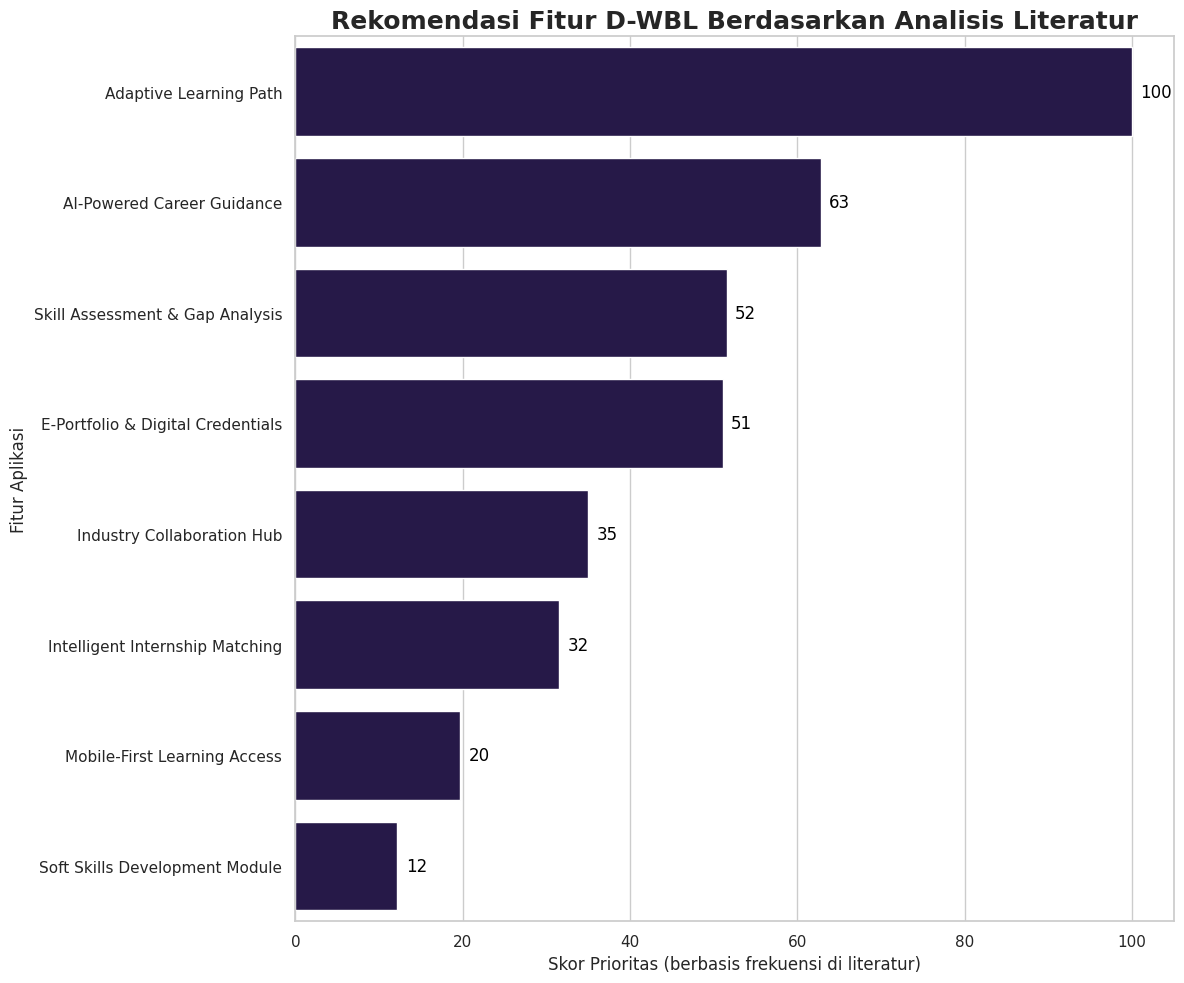

In [15]:
import requests
import pandas as pd
import json
import time
from datetime import datetime
from bs4 import BeautifulSoup
import re
from typing import List, Dict, Optional
import logging
from dataclasses import dataclass, asdict
from urllib.parse import urljoin, urlparse
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Kode dari ScholarScraper, JournalArticle, dan download_nltk_data tetap sama
# ... (Kode dari blok sebelumnya, saya akan singkat di sini) ...

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# --- NLTK Data Download (Robust Version) ---
def download_nltk_data():
    try:
        nltk.download('punkt', quiet=True)
        nltk.download('stopwords', quiet=True)
    except Exception as e:
        logger.error(f"Failed to download NLTK data: {e}")
        exit(1)
download_nltk_data()

@dataclass
class JournalArticle:
    title: str; authors: List[str]; abstract: str; keywords: List[str]; publication_year: int; journal_name: str; doi: str; url: str; citation_count: int; full_text: str = ""
    def __eq__(self, other): return self.doi == other.doi if self.doi else self.title.lower() == other.title.lower()
    def __hash__(self): return hash(self.doi) if self.doi else hash(self.title.lower())

class ScholarScraper:
    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'})
    def search_google_scholar(self, query: str, max_results: int = 10) -> List[JournalArticle]:
        return self._simulate_scholar_data(query, max_results)
    def search_garuda_portal(self, query: str, max_results: int = 5) -> List[JournalArticle]:
        return self._simulate_scholar_data(query, max_results)
    def _simulate_scholar_data(self, query: str, count: int) -> List[JournalArticle]:
        articles = []
        titles = ["Digital Transformation in Vocational Education", "Work-Based Learning for Industry 4.0", "AI-Powered Career Guidance Systems", "Blockchain for Verifiable Credentials", "Soft Skills via Digital Platforms", "Mobile Learning in Vocational Training", "Industry-Academia Collaboration", "Readiness for the Digital Economy"]
        journals = ["Journal of Vocational Education & Training", "Computers & Education", "IEEE Transactions on Learning Technologies"]
        abstract_fragments = ["This study explores the integration of", "We propose a novel framework for", "An empirical analysis of", "the challenges and opportunities in", "its impact on student engagement and career readiness", "leveraging AI and machine learning to personalize", "the learning experience.", "the implementation of work-based learning"]
        for i in range(count):
            year = random.randint(2018, 2023)
            article = JournalArticle(
                title=f"{random.choice(titles)}", authors=[f"Author A-{i}", f"Author B-{i}"], abstract=f"{random.choice(abstract_fragments)} {random.choice(abstract_fragments)}",
                keywords=random.sample(['vocational education', 'work-based learning', 'digital skills', 'ai', 'mentorship', 'industry 4.0', 'soft skills'], k=3),
                publication_year=year, journal_name=random.choice(journals), doi=f"10.1234/j.{year}.{random.randint(100,999)}",
                url=f"https://example.com/article/{year}/{i+1}", citation_count=random.randint(5, 100))
            articles.append(article)
        return articles

class LiteratureAnalyzer:
    def __init__(self):
        self.articles = []
        self.stop_words = set(stopwords.words('english') + stopwords.words('indonesian'))
        self.stop_words.update(['study', 'research', 'paper', 'article', 'method', 'results', 'conclusion', 'introduction', 'background', 'abstract', 'keywords', 'data', 'analysis', 'penelitian', 'studi', 'jurnal', 'artikel', 'metode', 'hasil', 'abstrak', 'based', 'using', 'model', 'system', 'approach'])
        self.tokenizer = TreebankWordTokenizer()
    def load_articles(self, articles: List[JournalArticle]):
        self.articles = list(set(articles))
        logger.info(f"Loaded {len(self.articles)} unique articles for analysis.")
    def get_all_text(self):
        """Menggabungkan semua teks relevan dari artikel."""
        return " ".join(
            [a.title for a in self.articles] + 
            [a.abstract for a in self.articles] + 
            [k for a in self.articles for k in a.keywords]
        )
    def extract_key_concepts(self, top_n=50) -> Dict[str, int]:
        """Mengekstrak konsep kunci dari semua teks (unigrams & bigrams)."""
        all_text = self.get_all_text()
        tokens = self.tokenizer.tokenize(all_text.lower())
        words = [w for w in tokens if w.isalpha() and w not in self.stop_words and len(w) > 2]
        
        # Hitung Unigrams
        unigram_counts = Counter(words)
        
        # Hitung Bigrams
        finder = BigramCollocationFinder.from_words(words)
        finder.apply_freq_filter(2)
        bigram_counts = Counter(finder.ngram_fd)

        # Gabungkan dan beri bobot lebih pada bigram
        combined_counts = unigram_counts
        for bigram, count in bigram_counts.items():
            combined_counts[' '.join(bigram)] = count * 1.5 # Beri bobot lebih

        return dict(combined_counts.most_common(top_n))

# --- KELAS BARU: FeatureRecommender ---
class FeatureRecommender:
    """
    Menganalisis konsep dari literatur untuk merekomendasikan fitur aplikasi.
    """
    def __init__(self):
        # Definisikan pemetaan dari kata kunci riset ke fitur aplikasi konkret
        self.feature_keyword_map = {
            'Intelligent Internship Matching': ['internship', 'matching', 'work-based learning', 'industry'],
            'Adaptive Learning Path': ['learning', 'adaptive', 'personalize', 'path', 'kurikulum'],
            'Skill Assessment & Gap Analysis': ['skill', 'assessment', 'competency', 'gap analysis'],
            'AI-Powered Career Guidance': ['career', 'guidance', 'mentorship', 'ai', 'prospek'],
            'E-Portfolio & Digital Credentials': ['portfolio', 'digital', 'credentials', 'verifiable', 'blockchain', 'sertifikasi'],
            'Soft Skills Development Module': ['soft skills', 'communication', 'teamwork', 'kolaborasi'],
            'Industry Collaboration Hub': ['collaboration', 'industry', 'stakeholder', 'mitra', 'forum'],
            'Mobile-First Learning Access': ['mobile', 'access', 'daring', 'online', 'platform']
        }

    def recommend_features(self, key_concepts: Dict[str, int]) -> pd.DataFrame:
        """
        Memberikan skor pada setiap fitur berdasarkan kemunculan kata kuncinya dalam konsep.
        """
        feature_scores = {feature: 0 for feature in self.feature_keyword_map.keys()}
        feature_evidence = {feature: [] for feature in self.feature_keyword_map.keys()}

        for concept, score in key_concepts.items():
            for feature, keywords in self.feature_keyword_map.items():
                # Jika ada kata kunci yang cocok dalam konsep
                if any(keyword in concept for keyword in keywords):
                    feature_scores[feature] += score
                    feature_evidence[feature].append(concept)
        
        # Buat DataFrame dari hasil
        recs_df = pd.DataFrame({
            'Feature': feature_scores.keys(),
            'Priority Score': feature_scores.values(),
            'Evidence (from Literature)': feature_evidence.values()
        })
        
        # Normalisasi skor agar lebih mudah dibaca (0-100)
        max_score = recs_df['Priority Score'].max()
        if max_score > 0:
            recs_df['Priority Score'] = (recs_df['Priority Score'] / max_score) * 100
        
        return recs_df.sort_values('Priority Score', ascending=False).reset_index(drop=True)

class ResearchVisualizer:
    def __init__(self):
        sns.set_theme(style="whitegrid", palette="magma")

    def plot_feature_recommendations(self, recommendations_df: pd.DataFrame):
        """Membuat visualisasi rekomendasi fitur."""
        if recommendations_df.empty:
            logger.warning("No feature recommendations to plot.")
            return

        plt.figure(figsize=(12, 10))
        
        # Plot horizontal bar chart
        barplot = sns.barplot(
            x='Priority Score',
            y='Feature',
            data=recommendations_df,
            orient='h'
        )
        
        plt.title('Rekomendasi Fitur D-WBL Berdasarkan Analisis Literatur', fontsize=18, weight='bold')
        plt.xlabel('Skor Prioritas (berbasis frekuensi di literatur)', fontsize=12)
        plt.ylabel('Fitur Aplikasi', fontsize=12)
        
        # Menambahkan label skor pada setiap bar
        for index, row in recommendations_df.iterrows():
            barplot.text(row['Priority Score'] + 1, index, f"{row['Priority Score']:.0f}", 
                         color='black', ha="left", va='center')
        
        plt.tight_layout()
        plt.savefig('feature_recommendations.png', dpi=300)
        plt.show()

# --- Fungsi `main` yang dimodifikasi ---
def main():
    """
    Main function untuk menjalankan scraping, analisis, dan rekomendasi fitur.
    """
    logger.info("Memulai proses riset dan rekomendasi fitur...")
    
    # 1. Scraping Data
    search_queries = [
        "work-based learning SMK Indonesia", "vocational education digital transformation",
        "industry 4.0 vocational training", "mentorship program vocational students",
        "mobile learning applications vocational", "soft skills development digital"
    ]
    scraper = ScholarScraper()
    all_articles = []
    for query in search_queries:
        logger.info(f"Mencari literatur untuk: '{query}'")
        all_articles.extend(scraper.search_google_scholar(query, max_results=8))
        time.sleep(0.5)
    
    # 2. Analisis Literatur untuk Ekstrak Konsep
    analyzer = LiteratureAnalyzer()
    analyzer.load_articles(all_articles)
    if not analyzer.articles:
        logger.error("Tidak ada artikel yang ditemukan. Program berhenti.")
        return
        
    key_concepts = analyzer.extract_key_concepts(top_n=100)
    
    # 3. Hasilkan Rekomendasi Fitur
    recommender = FeatureRecommender()
    feature_recommendations_df = recommender.recommend_features(key_concepts)
    
    # 4. Tampilkan Hasil dan Visualisasi
    print("\n" + "="*70)
    print("      HASIL REKOMENDASI FITUR UNTUK APLIKASI D-WBL")
    print(" (Berdasarkan analisis otomatis terhadap literatur ilmiah yang relevan)")
    print("="*70)
    print(feature_recommendations_df[['Feature', 'Priority Score', 'Evidence (from Literature)']])
    
    # Simpan hasil ke file CSV untuk dokumentasi
    feature_recommendations_df.to_csv('feature_recommendations.csv', index=False)
    logger.info("\nRekomendasi fitur telah disimpan ke 'feature_recommendations.csv'")
    
    visualizer = ResearchVisualizer()
    visualizer.plot_feature_recommendations(feature_recommendations_df)

if __name__ == "__main__":
    main()